In [5]:
import datetime
import time
import pickle
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import os
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge

start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')




Features list length: 154


In [6]:
# Definér folder_name, så alle paths kan ændres ét sted
folder_name = "new_data"


file_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf.parquet")
file_path_usa = os.path.join(".", folder_name, "usa_rvol.parquet")
file_path_id_test = os.path.join(".", folder_name, "top_5_percent_ids.csv")
file_path_market_returns = os.path.join(".", folder_name, "market_returns_test.csv")
output_path_usa_dsf = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
output_path_market_returns = os.path.join(folder_name, "market_returns_test.csv")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")
output_path = os.path.join(".", folder_name, "")  

file_path_usa_test = os.path.join(".", folder_name, "usa_test.parquet")
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
file_path_world_ret = os.path.join(".", folder_name, "world_ret_test.csv")  # gentaget hvis nødvendigt
risk_free_path = os.path.join(".", folder_name, "risk_free_test.csv")
market_path = os.path.join(".", folder_name, "market_returns_test.csv")

# Definér datoer
start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')

# Processering af risk_free med data_run_files
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date, output_path = risk_free_path)

# Udregning af wealth
wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(market_path)
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)
h_list = [1]  # Horisonter

Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som .\new_data\risk_free_test.csv
Filen er indlæst og filtreret succesfuldt.


In [15]:
# billede outputfolder
output_folder = r"C:\Users\andre\Documents\4. semester Kandidatspeciale\Billeder direkte fra koden"


## hælpefunktion:

In [4]:
def long_horizon_ret(data, h, impute):
    # Udvælg unikke datoer for observationer med ikke-missing ret_exc
    # Vi beholder kun én kolonne, og kalder den 'merge_date'
    dates = data.loc[data['ret_exc'].notna(), ['eom']].drop_duplicates().rename(columns={'eom': 'merge_date'})
    
    # Beregn start- og slutdato for hver id (kun for de observationer, hvor ret_exc ikke er missing)
    ids = data.loc[data['ret_exc'].notna()].groupby('id').agg(start=('eom', 'min'),
                                                               end=('eom', 'max')).reset_index()
    
    # Udfør en cross join mellem ids og dates
    full_ret = ids.merge(dates, how='cross')
    
    # Filtrer, så kun de rækker bevares, hvor merge_date ligger mellem start og end
    full_ret = full_ret[(full_ret['merge_date'] >= full_ret['start']) & (full_ret['merge_date'] <= full_ret['end'])]
    
    # Drop start- og end-kolonnerne, og omdøb merge_date til eom
    full_ret = full_ret.drop(columns=['start', 'end']).rename(columns={'merge_date': 'eom'})
    
    # Merge med de originale data for at få ret_exc
    full_ret = full_ret.merge(data[['id', 'eom', 'ret_exc']], on=['id', 'eom'], how='left')
    
    # Sortér efter id og eom
    full_ret = full_ret.sort_values(['id', 'eom']).reset_index(drop=True)
    
    # Opret kolonner for long horizon returns: ret_ld1, ret_ld2, ..., ret_ld{h}
    for l in range(1, h + 1):
        full_ret[f'ret_ld{l}'] = full_ret.groupby('id')['ret_exc'].shift(-l)
    
    # Fjern den oprindelige ret_exc-kolonne
    full_ret.drop(columns=['ret_exc'], inplace=True)
    
    # Fjern rækker, hvor alle ret_ld-kolonner er missing
    lag_cols = [f'ret_ld{l}' for l in range(1, h + 1)]
    all_missing = full_ret[lag_cols].isna().all(axis=1)
    print(f"All missing excludes {all_missing.mean() * 100:.2f}% of the observations")
    full_ret = full_ret[~all_missing].reset_index(drop=True)
    
    # Imputering af manglende værdier
    if impute == "zero":
        full_ret[lag_cols] = full_ret[lag_cols].fillna(0)
    elif impute == "mean":
        # Imputer pr. eom
        full_ret[lag_cols] = full_ret.groupby('eom')[lag_cols].transform(lambda x: x.fillna(x.mean()))
    elif impute == "median":
        full_ret[lag_cols] = full_ret.groupby('eom')[lag_cols].transform(lambda x: x.fillna(x.median()))
    
    return full_ret


## Skab data_ret_ld1

In [5]:

world_ret = pd.read_csv(file_path_world_ret, usecols=["excntry", "id", "eom", "ret_exc"], dtype={"eom": str})
filtered_world_ret = world_ret[(world_ret["excntry"] == "USA") & (world_ret["id"] <= 99999)].copy()
filtered_world_ret["eom"] = pd.to_datetime(filtered_world_ret["eom"])
monthly = filtered_world_ret
data_ret = long_horizon_ret(filtered_world_ret, h=12, impute="zero")
data_ret_ld1 = data_ret.copy()
data_ret_ld1['eom_ret'] = (data_ret_ld1['eom'] + pd.DateOffset(months=1)) + MonthEnd(0)
data_ret_ld1 = data_ret_ld1[['id', 'eom', 'eom_ret', 'ret_ld1']]
data_ret_ld1 = data_ret_ld1.merge(risk_free, on='eom', how='left')
data_ret_ld1['tr_ld1'] = data_ret_ld1['ret_ld1'] + data_ret_ld1['rf']
data_ret_ld1.drop(columns=['rf'], inplace=True)
temp = data_ret_ld1[['id', 'eom', 'tr_ld1']].copy()

temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)

temp = temp.rename(columns={'tr_ld1': 'tr_ld0'})

data_ret_ld1 = data_ret_ld1.merge(temp, on=['id', 'eom'], how='left')
data_ret_ld1

All missing excludes 0.42% of the observations


,id,eom,eom_ret,ret_ld1,tr_ld1,tr_ld0
0,10104,1986-04-30,1986-05-31,-0.064934,-0.059734,NaN
1,10104,1986-05-31,1986-06-30,0.031988,0.036888,-0.059734
2,10104,1986-06-30,1986-07-31,-0.369114,-0.363914,0.036888
3,10104,1986-07-31,1986-08-31,0.059902,0.065102,-0.363914
4,10104,1986-08-31,1986-09-30,-0.141147,-0.136547,0.065102
...,...,...,...,...,...,...
159423,92655,2022-07-31,2022-08-31,-0.044328,-0.043528,0.055684
159424,92655,2022-08-31,2022-09-30,-0.026268,-0.024368,-0.043528
159425,92655,2022-09-30,2022-10-31,0.096893,0.098793,-0.024368
159426,92655,2022-10-31,2022-11-30,-0.016168,-0.013868,0.098793


## chars

In [6]:
chars = pd.read_parquet(output_path_usa)
print("Dimensioner for fulde data:")
print(chars.shape)

# ---------------------------------------------------------
# 2. Definér de kolonner, der skal hentes (unik liste)
# Her antages, at 'features' er en liste med ekstra kolonnenavne
selected_cols = list(set(["id", "eom", "sic", "size_grp", "me", "rvol_252d", "dolvol_126d"] + features))
# Læs kun de nødvendige kolonner fra Parquet-filen
chars = pd.read_parquet(output_path_usa, columns=selected_cols)

chars = chars[chars['id'] <= 99999]
chars['eom'] = pd.to_datetime(chars['eom'])

print("Dimensioner efter valg af kolonner:")

print(chars.shape)

chars['dolvol'] = chars['dolvol_126d']
# b) 'lambda' beregnes som 2/dolvol * settings['pi']
chars['lambda'] = 2 / chars['dolvol'] * settings['pi']
# c) 'rvol_m' beregnes som rvol_252d * sqrt(21)
chars['rvol_m'] = chars['rvol_252d'] * np.sqrt(21)

chars = pd.merge(chars, data_ret_ld1, on=['id', 'eom'], how='left')


temp = wealth.copy()
# Flyt eom til den sidste dag i næste måned:
temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)
# Omdøb 'mu_ld1' til 'mu_ld0'
temp = temp.rename(columns={'mu_ld1': 'mu_ld0'})
# Merge wealth-data med chars på kolonnen eom
chars = pd.merge(chars, temp[['eom', 'mu_ld0']], on='eom', how='left')
print("Data efter merge med data_ret_ld1:")
print(chars.shape)

# Date screen: Udregn andelen af rækker, hvor eom ligger uden for screens-intervallet
date_excludes = ((chars['eom'] < settings['screens']['start']) | (chars['eom'] > settings['screens']['end'])).mean() * 100
print(f"   Date screen excludes {date_excludes:.2f}% of the observations")

# Filtrer data, så kun rækker med eom inden for intervallet beholdes
chars = chars[(chars['eom'] >= settings['screens']['start']) & (chars['eom'] <= settings['screens']['end'])]
print("Dim after date screen:", chars.shape)

# Monitor screen impact
n_start = chars.shape[0]
me_start = chars['me'].sum(skipna=True)

# Require non-missing me
me_missing_pct = chars['me'].isna().mean() * 100
print(f"   Non-missing me excludes {me_missing_pct:.2f}% of the observations")
chars = chars[~chars['me'].isna()]

# Require non-missing return for t og t+1: (tr_ld1 og tr_ld0)
valid_return_excludes = ((chars['tr_ld1'].isna()) | (chars['tr_ld0'].isna())).mean() * 100
print(f"   Valid return req excludes {valid_return_excludes:.2f}% of the observations")
chars = chars[chars['tr_ld0'].notna() & chars['tr_ld1'].notna()]

print("Final dim:", chars.shape)


Dimensioner for fulde data:
(153887, 164)
Dimensioner efter valg af kolonner:
(153887, 120)
Data efter merge med data_ret_ld1:
(153887, 128)
   Date screen excludes 18.44% of the observations
Dim after date screen: (125503, 128)
   Non-missing me excludes 0.00% of the observations
   Valid return req excludes 0.25% of the observations
Final dim: (125193, 128)


In [7]:
dolvol_excludes = ((chars['dolvol'].isna()) | (chars['dolvol'] == 0)).mean() * 100
print(f"   Non-missing/non-zero dolvol excludes {dolvol_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'dolvol' ikke er missing og > 0
chars = chars[(~chars['dolvol'].isna()) & (chars['dolvol'] > 0)]

# --- Require valid SIC code ---
# Beregn andelen af observationer med en tom SIC (""), svarende til R's mean(chars$sic=="")
sic_excludes = (chars['sic'] == "").mean() * 100
print(f"   Valid SIC code excludes {sic_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'sic' ikke er missing
chars = chars[~chars['sic'].isna()]

# --- Feature screens ---
# For hver række beregnes antallet af ikke-missing feature-værdier (for de kolonner, der er defineret i 'features')
feat_available = chars[features].notna().sum(axis=1)

# Minimum antal features, som kræves: floor(antal features * settings['screens']['feat_pct'])
min_feat = int(np.floor(len(features) * settings['screens']['feat_pct']))

# Udregn procentdelen af observationer, hvor antallet af tilgængelige features er mindre end min_feat
feat_excludes = (feat_available < min_feat).mean() * 100
print(f"   At least {settings['screens']['feat_pct']*100:.0f}% of feature excludes {feat_excludes:.2f}% of the observations")

# Filtrer rækker, hvor antallet af tilgængelige features er >= min_feat
chars = chars[feat_available >= min_feat]
print("Final dimensions after feature screen:", chars.shape)

   Non-missing/non-zero dolvol excludes 0.03% of the observations
   Valid SIC code excludes 0.03% of the observations
   At least 50% of feature excludes 0.00% of the observations
Final dimensions after feature screen: (125158, 128)


In [8]:
final_obs_pct = (len(chars) / n_start) * 100
final_me_pct = (chars['me'].sum() / me_start) * 100
print(f"   In total, the final dataset has {final_obs_pct:.2f}% of the observations and {final_me_pct:.2f}% of the market cap in the post {settings['screens']['start']} data")
run_sub = False
if run_sub:
    np.random.seed(settings['seed'])
    unique_ids = chars['id'].unique()
    sample_ids = np.random.choice(unique_ids, size=2500, replace=False)
    chars = chars[chars['id'].isin(sample_ids)]
if settings['feat_prank']:
    # Konverter feature-kolonner til float (dobbelt præcision)
    chars[features] = chars[features].astype(float)
    
    def ecdf_transform(s):
        return s.rank(method='average', pct=True)
    
    for i, f in enumerate(features):
        if (i + 1) % 10 == 0:
            print(f"Feature {i+1} out of {len(features)}")
        
        # Gem en lokal variabel med indikator for nøjagtige nuller
        zero = (chars[f] == 0)
        
        # Udfør ECDF-transformation per gruppe defineret af 'eom'
        chars[f] = chars.groupby('eom')[f].transform(lambda s: ecdf_transform(s))
        
        # Sæt de oprindelige 0-værdier tilbage til 0
        chars.loc[zero, f] = 0


   In total, the final dataset has 99.73% of the observations and 99.37% of the market cap in the post 1982-12-31 00:00:00 data
Feature 10 out of 115
Feature 20 out of 115
Feature 30 out of 115
Feature 40 out of 115
Feature 50 out of 115
Feature 60 out of 115
Feature 70 out of 115
Feature 80 out of 115
Feature 90 out of 115
Feature 100 out of 115
Feature 110 out of 115


In [9]:
if settings['feat_impute']:
    if settings['feat_prank']:
        # For hvert feature: hvis manglende, sæt til 0.5
        for f in features:
            chars[f] = chars[f].fillna(0.5)
    else:
        # For hvert feature: imputér manglende værdier med median inden for hver eom-gruppe
        for f in features:
            chars[f] = chars.groupby('eom')[f].transform(lambda s: s.fillna(s.median()))


In [10]:
# Konverter sic til numerisk (fejl konverteres til NaN)
chars['sic'] = pd.to_numeric(chars['sic'], errors='coerce')


cond_no_dur = (
    chars['sic'].between(100, 999) |
    chars['sic'].between(2000, 2399) |
    chars['sic'].between(2700, 2749) |
    chars['sic'].between(2770, 2799) |
    chars['sic'].between(3100, 3199) |
    chars['sic'].between(3940, 3989)
)

cond_durbl = (
    chars['sic'].between(2500, 2519) |
    chars['sic'].between(3630, 3659) |
    chars['sic'].isin([3710, 3711, 3714, 3716]) |
    chars['sic'].between(3750, 3751) |
    (chars['sic'] == 3792) |
    chars['sic'].between(3900, 3939) |
    chars['sic'].between(3990, 3999)
)

cond_manuf = (
    chars['sic'].between(2520, 2589) |
    chars['sic'].between(2600, 2699) |
    chars['sic'].between(2750, 2769) |
    chars['sic'].between(3000, 3099) |
    chars['sic'].between(3200, 3569) |
    chars['sic'].between(3580, 3629) |
    chars['sic'].between(3700, 3709) |
    chars['sic'].between(3712, 3713) |
    (chars['sic'] == 3715) |
    chars['sic'].between(3717, 3749) |
    chars['sic'].between(3752, 3791) |
    chars['sic'].between(3793, 3799) |
    chars['sic'].between(3830, 3839) |
    chars['sic'].between(3860, 3899)
)

cond_enrgy = (
    chars['sic'].between(1200, 1399) |
    chars['sic'].between(2900, 2999)
)

cond_chems = (
    chars['sic'].between(2800, 2829) |
    chars['sic'].between(2840, 2899)
)

cond_buseq = (
    chars['sic'].between(3570, 3579) |
    chars['sic'].between(3660, 3692) |
    chars['sic'].between(3694, 3699) |
    chars['sic'].between(3810, 3829) |
    chars['sic'].between(7370, 7379)
)

cond_telcm = chars['sic'].between(4800, 4899)
cond_utils = chars['sic'].between(4900, 4949)

cond_shops = (
    chars['sic'].between(5000, 5999) |
    chars['sic'].between(7200, 7299) |
    chars['sic'].between(7600, 7699)
)

cond_hlth = (
    chars['sic'].between(2830, 2839) |
    (chars['sic'] == 3693) |
    chars['sic'].between(3840, 3859) |
    chars['sic'].between(8000, 8099)
)

cond_money = chars['sic'].between(6000, 6999)

# Saml betingelser og tilhørende valg
conditions = [
    cond_no_dur,
    cond_durbl,
    cond_manuf,
    cond_enrgy,
    cond_chems,
    cond_buseq,
    cond_telcm,
    cond_utils,
    cond_shops,
    cond_hlth,
    cond_money
]

choices = [
    "NoDur",
    "Durbl",
    "Manuf",
    "Enrgy",
    "Chems",
    "BusEq",
    "Telcm",
    "Utils",
    "Shops",
    "Hlth",
    "Money"
]

# Opret kolonnen ff12 med værdien "Other", hvis ingen betingelser er opfyldte
chars['ff12'] = np.select(conditions, choices, default="Other")

C:\Users\andre\AppData\Local\Temp\ipykernel_7076\1530898857.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  chars['ff12'] = np.select(conditions, choices, default="Other")


In [11]:
# Først: sortér DataFrame (ingen indsættelser sker her)
chars.sort_values(['id', 'eom'], inplace=True)

# Beregn lb
lb = pf_set['lb_hor'] + 1

# Beregn eom_lag og month_diff som separate serier
eom_lag_series = chars.groupby('id')['eom'].shift(lb)

def calc_month_diff(row):
    # Hvis eom_lag er NaT, returner NaN
    if pd.isna(row['eom_lag']):
        return np.nan
    return (row['eom'].year - row['eom_lag'].year) * 12 + (row['eom'].month - row['eom_lag'].month)

# Lav en midlertidig DataFrame for beregninger (uden at ændre chars løbende)
temp_df = pd.concat([chars['eom'], eom_lag_series.rename('eom_lag')], axis=1)
temp_df['month_diff'] = temp_df.apply(lambda row: calc_month_diff(row), axis=1)

# Udregn exclusion rate (for de rækker hvor valid_data oprindeligt er True)
# Her antages alle observationer at være gyldige til at starte med
exclusion_rate = (((temp_df['month_diff'] != lb) | (temp_df['month_diff'].isna())).mean()) * 100
print(f"   Valid lookback observation screen excludes {exclusion_rate:.2f}% of the observations")

# Opdater valid_data: kun rækker med month_diff lig lb og ikke NaN er gyldige
valid_data_series = (temp_df['month_diff'] == lb) & (~temp_df['month_diff'].isna())

# Tilføj valid_data til chars ved at bruge pd.concat (samler alle nye kolonner på én gang)
new_cols = pd.DataFrame({
    'valid_data': valid_data_series,
    'eom_lag': temp_df['eom_lag'],
    'month_diff': temp_df['month_diff']
}, index=chars.index)

chars = pd.concat([chars, new_cols], axis=1)

# Opdater valid_data-kolonnen i chars
chars['valid_data'] = chars['valid_data']

# Fjern de midlertidige kolonner
chars.drop(columns=['eom_lag', 'month_diff'], inplace=True)


   Valid lookback observation screen excludes 3.60% of the observations


In [12]:
dates = sorted(op.keys())

# Plot 1: Optimal Lambda over tid
opt_lambdas = [model_1[d]['opt_hps']['lambda'] for d in dates]
plt.figure(figsize=(10,6))
plt.plot(dates, opt_lambdas, marker='o', label='Optimal Lambda')
plt.xlabel('Validation End Date')
plt.ylabel('Lambda')
plt.title('Optimal Lambda Over Time')
plt.legend()
plt.show()



NameError: name 'op' is not defined

In [118]:
## Hjælpefunktioner

In [13]:
def investment_universe(add, delete):
    """
    Beregner en logisk vektor, der angiver om et aktiv (i en tidsserie)
    skal inkluderes i investeringsuniverset.
    
    Parametre:
      add (list eller 1D-array af bool): Tilføjningsflag pr. periode.
      delete (list eller 1D-array af bool): Sletningsflag pr. periode.
      
    Returnerer:
      included (list af bool): Resultat for hver periode.
    """
    n = len(add)
    included = [False] * n
    state = False
    # Start fra anden observation (python-indeks 1)
    for i in range(1, n):
        # Inkludér hvis aktivet ikke er inkluderet,
        # men får et tilføjningssignal nu (og ikke fik signal i forrige periode)
        if (not state) and add[i] and (not add[i-1]):
            state = True
        # Fjern aktivet hvis det er inkluderet og får sletningssignal
        if state and delete[i]:
            state = False
        included[i] = state
    return included


In [14]:
import re

def size_screen_fun(chars, type_screen):
    """
    Size-based screen function. Modifies DataFrame 'chars' in place.
    
    Parametre:
      chars (pd.DataFrame): DataFrame med mindst kolonnerne 'valid_data', 'me',
                            og evt. 'size_grp'.
      type_screen (str): Angiver, hvilken type screen der skal anvendes. Skal være
                         præcis én af:
                           - "all"
                           - "topN" (f.eks. "top1000")
                           - "bottomN" (f.eks. "bottom100")
                           - "size_grp_{gruppe}" (f.eks. "size_grp_small")
                           - En procent-baseret string indeholdende "perc", "low", "high" og "min"
                             f.eks. "perc_low20high80min50"
    
    Funktionen tjekker, at præcis én screen-type er anvendt. Hvis ikke, kastes en fejl.
    """
    count = 0
    # --- Screen: All ---
    if type_screen == "all":
        print("No size screen")
        chars.loc[chars['valid_data'] == True, 'valid_size'] = True
        count += 1

    # --- Screen: Top N ---
    if "top" in type_screen:
        # Ekstraher tallet fra strengen (fjerner alle ikke-cifrede tegn)
        top_n = int(re.sub(r"\D", "", type_screen))
        # For rækker hvor valid_data er True, beregn rangeringen af me (descending) inden for hver eom
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=False, method='first')
        # Sæt valid_size til True, hvis me_rank <= top_n og me_rank ikke er NA
        chars['valid_size'] = (chars['me_rank'] <= top_n) & (~chars['me_rank'].isna())
        # Fjern den midlertidige kolonne
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Bottom N ---
    if "bottom" in type_screen:
        bot_n = int(re.sub(r"\D", "", type_screen))
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=True, method='first')
        chars['valid_size'] = (chars['me_rank'] <= bot_n) & (~chars['me_rank'].isna())
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Size group ---
    if "size_grp_" in type_screen:
        size_grp_screen = type_screen.replace("size_grp_", "")
        chars['valid_size'] = (chars['size_grp'] == size_grp_screen) & (chars['valid_data'] == True)
        count += 1

    # --- Screen: Percentile-based ---
    if "perc" in type_screen:
        low_match = re.search(r"(?<=low)\d+", type_screen)
        high_match = re.search(r"(?<=high)\d+", type_screen)
        min_match = re.search(r"(?<=min)\d+", type_screen)
        if low_match and high_match and min_match:
            low_p = int(low_match.group())
            high_p = int(high_match.group())
            min_n = int(min_match.group())
        else:
            raise ValueError("Percentile screen format invalid.")
        print(f"Percentile-based screening: Range {low_p}% - {high_p}%, min_n: {min_n} stocks")
        # For rækker hvor valid_data er True: beregn ECDF for me inden for hver eom (brug rank i procent)
        chars.loc[chars['valid_data'] == True, 'me_perc'] = chars.groupby('eom')['me'].transform(lambda s: s.rank(method='average', pct=True))
        # Sæt valid_size til True, hvis me_perc ligger inden for (low_p/100, high_p/100]
        chars['valid_size'] = (chars['me_perc'] > (low_p / 100)) & (chars['me_perc'] <= (high_p / 100)) & (~chars['me_perc'].isna())
        # Beregn gruppe-specifik statistik for hver eom
        group_stats = chars.groupby('eom').apply(lambda g: pd.Series({
            'n_tot': g['valid_data'].sum(),
            'n_size': g['valid_size'].sum(),
            'n_less': ((g['valid_data'] == True) & (g['me_perc'] <= (low_p / 100))).sum(),
            'n_more': ((g['valid_data'] == True) & (g['me_perc'] > (high_p / 100))).sum()
        }))
        # Merge disse stats tilbage til chars
        chars = chars.merge(group_stats, left_on='eom', right_index=True, how='left')
        # Beregn antallet af manglende aktier, der skal tilføjes
        chars['n_miss'] = np.maximum(min_n - chars['n_size'], 0)
        # Beregn hvor mange aktier der skal tilføjes fra neden og ovenfra
        chars['n_below'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_less']))
        chars['n_above'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_more']))
        # Juster, hvis summen af n_below og n_above er mindre end n_miss
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] > chars['n_below'])
        chars.loc[cond, 'n_above'] = chars.loc[cond, 'n_above'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] < chars['n_below'])
        chars.loc[cond, 'n_below'] = chars.loc[cond, 'n_below'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        # Endelig: sæt valid_size, med en udvidet grænse baseret på de beregnede tilføjelser
        chars['valid_size'] = (chars['me_perc'] > (low_p/100 - chars['n_below']/chars['n_tot'])) & \
                              (chars['me_perc'] <= (high_p/100 + chars['n_above']/chars['n_tot'])) & \
                              (~chars['me_perc'].isna())
        # Fjern de midlertidige kolonner
        for col in ['me_perc', 'n_tot', 'n_size', 'n_less', 'n_more', 'n_miss', 'n_below', 'n_above']:
            if col in chars.columns:
                chars.drop(columns=col, inplace=True)
        count += 1

    if count != 1:
        raise ValueError("Invalid size screen applied!!!!")
    
    return chars


In [16]:
dates = sorted(demeaned_model_1.keys())

# Plot 1: Optimal Lambda over tid
opt_lambdas = [demeaned_model_1[d]['opt_hps']['lambda'] for d in dates]
plt.figure(figsize=(10,6))
plt.plot(dates, opt_lambdas, marker='o', label='Optimal Lambda')
plt.xlabel('Validation End Date')
plt.ylabel('Lambda')
plt.title('Optimal Lambda Over Time')
plt.legend()
plt.show()



NameError: name 'plt' is not defined

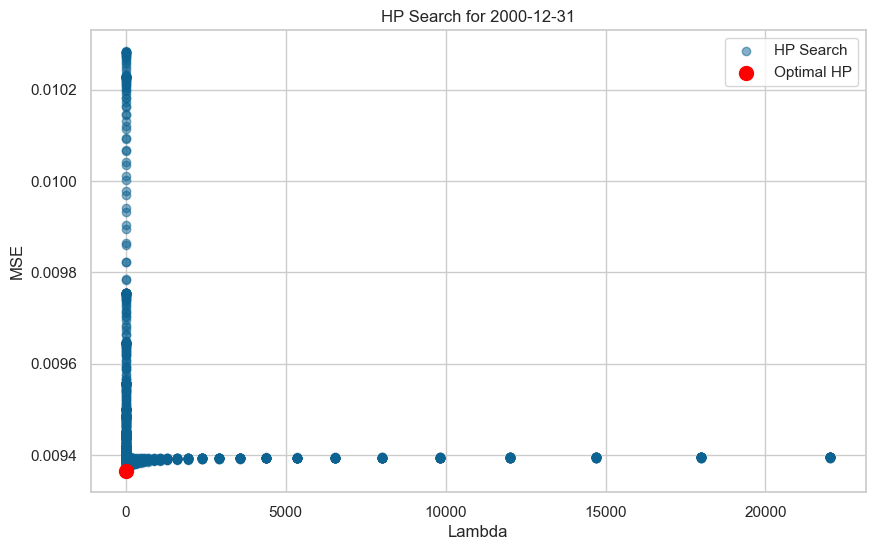

In [52]:
# Plot 2: HP Search Scatter Plot for en given periode (her den første dato)
date0 = dates[0]
hp_search_df = demeaned_model_1[date0]['hp_search']
plt.figure(figsize=(10,6))
plt.scatter(hp_search_df['lambda'], hp_search_df['mse'], alpha=0.5, label='HP Search')
# Marker den optimale hyperparameter
opt_point = demeaned_model_1[date0]['opt_hps']
plt.scatter(opt_point['lambda'], opt_point['mse'], color='red', label='Optimal HP', s=100)
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title(f'HP Search for {date0.date()}')
plt.legend()
plt.show()

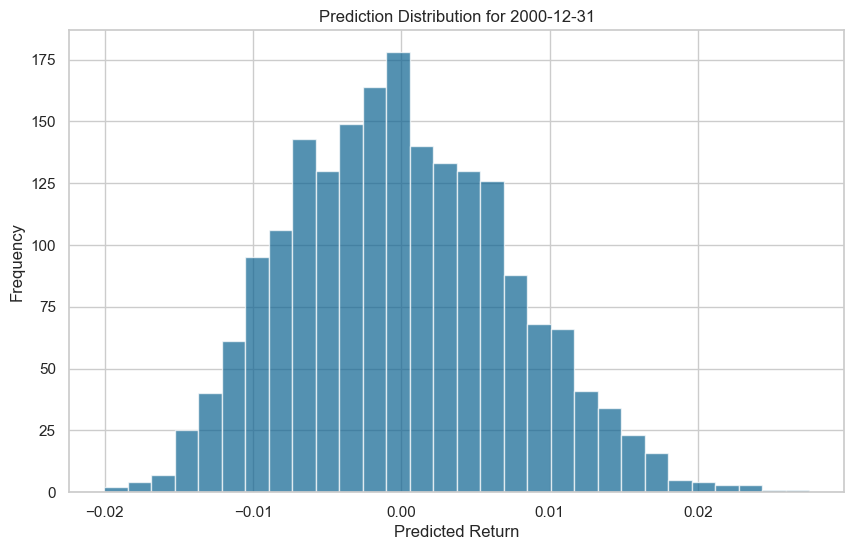

In [53]:
# Plot 3: Histogram af forudsigelser for en given periode
pred_df = demeaned_model_1[date0]['pred']
plt.figure(figsize=(10,6))
plt.hist(pred_df['pred'], bins=30, alpha=0.7)
plt.xlabel('Predicted Return')
plt.ylabel('Frequency')
plt.title(f'Prediction Distribution for {date0.date()}')
plt.show()

In [ ]:
# Plot 4: Histogram af vægte (W) for en given periode
W = model_1[date0]['W'].flatten()  # Gør arrayet til en 1D-array
plt.figure(figsize=(10,6))
plt.hist(W, bins=30, alpha=0.7)
plt.xlabel('Coefficient Values')
plt.ylabel('Frequency')
plt.title(f'Weight Distribution for {date0.date()}')
plt.show()

In [51]:
def addition_deletion_fun(chars, addition_n, deletion_n, pf_set):
    """
    Anvender addition/deletion-reglen på DataFrame 'chars'.
    
    Parametre:
      chars (pd.DataFrame): Datasættet med aktieobservationer.
      addition_n (int): Vindueslængde for addition (rullende sum).
      deletion_n (int): Vindueslængde for deletion (rullende sum).
      pf_set (dict): Indstillinger; herunder forventes pf_set['lb_hor'] at være defineret.
      
    Funktionen:
      - Opretter en midlertidig kolonne 'valid_temp' (valid_data AND valid_size)
      - Sorterer data efter id og eom.
      - Beregner rullende summer for valid_temp over vinduerne addition_n og deletion_n.
      - Definerer flagget 'add' (når addition_count == addition_n) og 'delete' (når deletion_count == 0).
      - For hver aktie (id) med mere end én observation, anvendes investment_universe til at udlede en kolonne 'valid'.
      - For aktier med kun én observation sættes valid til False.
      - Hvis valid_data er False, sættes valid til False.
      - Beregner turnover (ændring) både for den rå validitet (valid_temp) og den justerede validitet (valid).
      - Udregner og printer gennemsnitlig turnover pr. eom.
      - Fjerner de midlertidige kolonner.
    """
    # 1. Opret valid_temp
    chars['valid_temp'] = (chars['valid_data'] == True) & (chars['valid_size'] == True)
    
    # 2. Sortér efter id og eom
    chars.sort_values(['id', 'eom'], inplace=True)
    
    # 3. Beregn rullende summer for valid_temp inden for hver id
    chars['valid_int'] = chars['valid_temp'].astype(int)
    chars['addition_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=addition_n, min_periods=addition_n).sum())
    chars['deletion_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=deletion_n, min_periods=deletion_n).sum())
    
    # 4. Definer flag for addition og deletion
    chars['add'] = (chars['addition_count'] == addition_n)
    chars['add'] = chars['add'].fillna(False)
    chars['delete'] = (chars['deletion_count'] == 0)
    chars['delete'] = chars['delete'].fillna(False)
    
    # 5. Beregn antallet af observationer per id
    chars['n'] = chars.groupby('id')['id'].transform('count')
    
    # 6. Anvend investment_universe for at udlede 'valid'
    def apply_investment_universe(df):
        add_list = df['add'].tolist()
        delete_list = df['delete'].tolist()
        valid_list = investment_universe(add_list, delete_list)
        return pd.Series(valid_list, index=df.index)
    
    chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(
        lambda g: apply_investment_universe(g) if len(g) > 1 else False
    ).reset_index(level=0, drop=True)
    
    chars.loc[chars['n'] == 1, 'valid'] = False
    chars.loc[chars['valid_data'] == False, 'valid'] = False
    
    # 7. Beregn Turnover
    chars['chg_raw'] = chars.groupby('id')['valid_temp'].transform(lambda s: s != s.shift(1))
    chars['chg_adj'] = chars.groupby('id')['valid'].transform(lambda s: s != s.shift(1))
    
    chars['valid_temp_int'] = chars['valid_temp'].astype(int)
    chars['valid_int_new'] = chars['valid'].astype(int)
    chars['chg_raw_int'] = chars['chg_raw'].astype(int)
    chars['chg_adj_int'] = chars['chg_adj'].astype(int)
    
    # Aggreger pr. eom
    turnover = chars.groupby('eom').agg(
        raw_n = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        adj_n = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        raw = pd.NamedAgg(column='chg_raw_int', aggfunc='sum'),
        total_valid_temp = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        total_valid = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        adj_sum = pd.NamedAgg(column='chg_adj_int', aggfunc='sum')
    ).reset_index()
    
    turnover['raw'] = turnover.apply(lambda row: row['raw'] / row['total_valid_temp'] if row['total_valid_temp'] > 0 else np.nan, axis=1)
    turnover['adj'] = turnover.apply(lambda row: row['adj_sum'] / row['total_valid'] if row['total_valid'] > 0 else np.nan, axis=1)
    
    valid_turnover = turnover[(~turnover['raw'].isna()) & (~turnover['adj'].isna()) & (turnover['adj'] != 0)]
    
    # Her beregner vi gennemsnittet af turnover over alle eom
    mean_raw = valid_turnover['raw'].mean()
    mean_adj = valid_turnover['adj'].mean()
    
    print(f"Turnover wo addition/deletion rule: {mean_raw*100:.2f}%")
    print(f"Turnover w  addition/deletion rule: {mean_adj*100:.2f}%")
    
    # 8. Fjern midlertidige kolonner
    cols_to_drop = ['n', 'addition_count', 'deletion_count', 'add', 'delete', 
                    'valid_temp', 'valid_data', 'valid_size', 
                    'chg_raw', 'chg_adj', 'valid_temp_int', 'valid_int_new',
                    'chg_raw_int', 'chg_adj_int']
    chars.drop(columns=cols_to_drop, inplace=True)
    
    return chars


In [52]:
type_screen = "all"
chars = size_screen_fun(chars, type_screen)
#print(chars)
print(chars.shape)

No size screen
(125158, 131)


In [53]:
chars = addition_deletion_fun(chars, addition_n=settings['addition_n'], deletion_n=settings['deletion_n'], pf_set=settings)
print(chars)
print(chars.shape)

Turnover wo addition/deletion rule: 0.91%
Turnover w  addition/deletion rule: 1.66%
          ocf_me    fcf_me  cowc_gr1a  sale_gr1  seas_2_5na  ami_126d  \
0       0.568182  0.437500   0.952000  0.968153    0.500000  0.929936   
1       0.545455  0.515625   0.952000  0.968153    0.500000  0.929936   
2       0.515152  0.523438   0.952000  0.974522    0.500000  0.929936   
3       0.293233  0.573643   0.976190  0.987342    0.500000  0.905063   
4       0.274074  0.496241   0.975806  0.993711    0.500000  0.905660   
...          ...       ...        ...       ...         ...       ...   
153870  0.225806  0.399351   0.130742  0.519355    0.724919  0.035484   
153871  0.216828  0.400651   0.124113  0.533981    0.801948  0.019417   
153872  0.197411  0.381107   0.120567  0.543689    0.538961  0.019417   
153873  0.232258  0.425325   0.095745  0.634304    0.676375  0.019355   
153874  0.270968  0.470779   0.095745  0.644013    0.760518  0.019355   

        at_turnover  lnoa_gr1a  seas_2_

C:\Users\andre\AppData\Local\Temp\ipykernel_12308\4257758924.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(


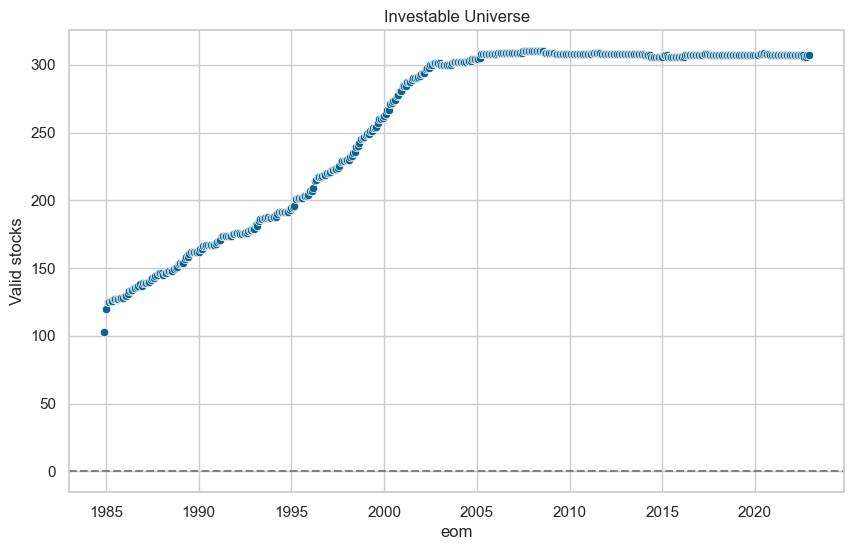

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns


valid_counts = chars.loc[chars['valid'] == True].groupby('eom').size().reset_index(name='N')

# Plot investable universe
plt.figure(figsize=(10,6))
sns.scatterplot(data=valid_counts, x='eom', y='N')
plt.ylabel("Valid stocks")
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Investable Universe")
plt.show()

In [55]:
valid_pct = (chars['valid'].mean() * 100)
market_cap_valid = (chars.loc[chars['valid'] == True, 'me'].sum() / chars['me'].sum()) * 100
print(f"   The valid_data subset has {valid_pct:.2f}% of the observations and {market_cap_valid:.2f}% of the market cap")

   The valid_data subset has 93.39% of the observations and 99.38% of the market cap


In [56]:
chars["valid_int"]

0         0
1         0
2         0
3         0
4         0
         ..
153870    1
153871    1
153872    1
153873    1
153874    1
Name: valid_int, Length: 125158, dtype: int32

In [57]:
chars.drop(columns="valid_int", inplace=True)


In [58]:
chars.shape

(125158, 130)

In [59]:
output_path_chars_behandlet =  os.path.join(".", folder_name, "chars_behandlet.parquet")
chars.to_parquet(output_path_chars_behandlet, index=False)

In [60]:
chars

,ocf_me,fcf_me,cowc_gr1a,sale_gr1,seas_2_5na,ami_126d,at_turnover,lnoa_gr1a,seas_2_5an,prc_highprc_252d,...,dolvol,lambda,rvol_m,eom_ret,ret_ld1,tr_ld1,tr_ld0,mu_ld0,ff12,valid
0,0.568182,0.437500,0.952000,0.968153,0.500000,0.929936,0.611465,0.973451,0.500000,0.165605,...,5.952293e+05,3.360050e-07,0.165542,1987-01-31,0.297054,0.301954,-0.035751,-0.026385,BusEq,False
1,0.545455,0.515625,0.952000,0.968153,0.500000,0.929936,0.649682,0.973684,0.500000,0.420382,...,9.014952e+05,2.218537e-07,0.170561,1987-02-28,0.421617,0.425817,0.301954,0.129587,BusEq,False
2,0.515152,0.523438,0.952000,0.974522,0.500000,0.929936,0.649682,0.973451,0.500000,0.964968,...,1.271623e+06,1.572793e-07,0.170986,1987-03-31,0.137845,0.142145,0.425817,0.048378,BusEq,False
3,0.293233,0.573643,0.976190,0.987342,0.500000,0.905063,0.835443,0.973451,0.500000,0.898734,...,1.463353e+06,1.366724e-07,0.173280,1987-04-30,0.063897,0.068597,0.142145,0.023201,BusEq,False
4,0.274074,0.496241,0.975806,0.993711,0.500000,0.905660,0.842767,0.940171,0.500000,0.572327,...,1.892803e+06,1.056634e-07,0.174032,1987-05-31,0.155814,0.160214,0.068597,-0.016540,BusEq,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153870,0.225806,0.399351,0.130742,0.519355,0.724919,0.035484,0.893548,0.683502,0.650485,0.970968,...,1.633418e+09,1.224426e-10,0.069191,2022-08-31,-0.044328,-0.043528,0.055684,0.093630,Money,True
153871,0.216828,0.400651,0.124113,0.533981,0.801948,0.019417,0.893204,0.682432,0.097403,0.925566,...,1.558158e+09,1.283567e-10,0.068704,2022-09-30,-0.026268,-0.024368,-0.043528,-0.036188,Money,True
153872,0.197411,0.381107,0.120567,0.543689,0.538961,0.019417,0.893204,0.685811,0.957792,0.957929,...,1.516174e+09,1.319110e-10,0.068843,2022-10-31,0.096893,0.098793,-0.024368,-0.091370,Money,True
153873,0.232258,0.425325,0.095745,0.634304,0.676375,0.019355,0.890323,0.831081,0.809061,0.975806,...,1.494588e+09,1.338161e-10,0.068225,2022-11-30,-0.016168,-0.013868,0.098793,0.081350,Money,True


In [61]:
market_test

,eom,mkt_vw_exc
0,1952-12-31,0.029113
1,1953-01-31,-0.003177
2,1953-02-28,-0.003027
3,1953-03-31,-0.014660
4,1953-04-30,-0.029152
...,...,...
836,2022-08-31,-0.038088
837,2022-09-30,-0.093270
838,2022-10-31,0.079050
839,2022-11-30,0.048429


C:\Users\andre\AppData\Local\Temp\ipykernel_7076\3626911540.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_returns = market_test.resample('Y', on='eom').mean()


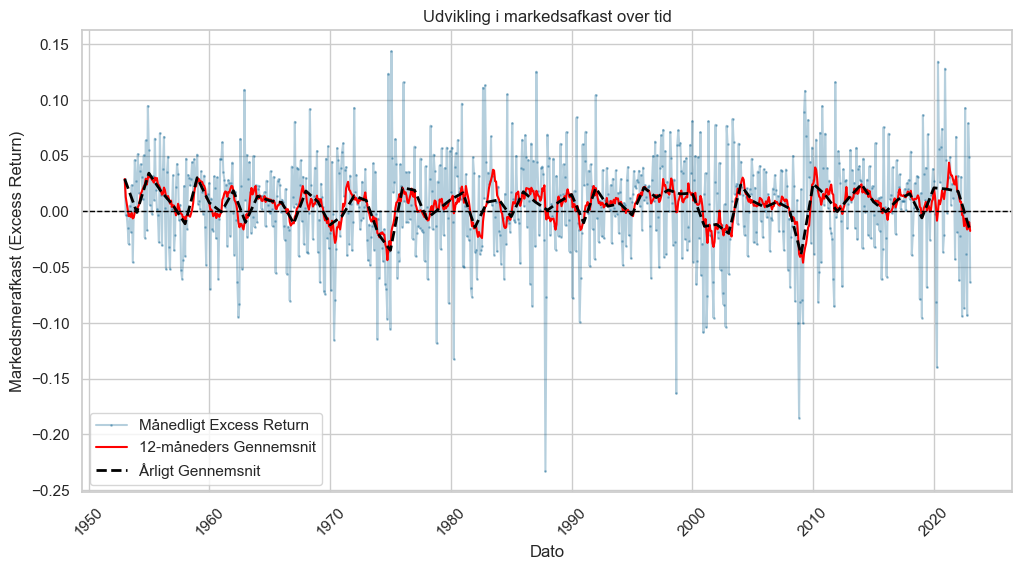

In [62]:
# Konverter eom til datetime-format
market_test['eom'] = pd.to_datetime(market_test['eom'])

# Beregn et 12-måneders glidende gennemsnit (1-års gennemsnit)
market_test['rolling_avg'] = market_test['mkt_vw_exc'].rolling(window=12, min_periods=1).mean()

# Resample data til årlige værdier for bedre overblik
annual_returns = market_test.resample('Y', on='eom').mean()

# Plot original data med lav alpha (gennemsigtighed)
plt.figure(figsize=(12, 6))
plt.plot(market_test['eom'], market_test['mkt_vw_exc'], linestyle='-', marker='o', markersize=1, alpha=0.3, label="Månedligt Excess Return")

# Tilføj glidende gennemsnit for en tydeligere trend
plt.plot(market_test['eom'], market_test['rolling_avg'], color='red', linewidth=1.5, label="12-måneders Gennemsnit")

# Tilføj årsresamplet trendlinje
plt.plot(annual_returns.index, annual_returns['mkt_vw_exc'], color='black', linestyle='dashed', linewidth=2, label="Årligt Gennemsnit")

# Tilføj en horisontal linje ved 0
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Formatering af plot
plt.xlabel("Dato")
plt.ylabel("Markedsmerafkast (Excess Return)")
plt.title("Udvikling i markedsafkast over tid")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Bedre læsbarhed af datoer

# Vis plot
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_7076\3057477848.py:30: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_7076\3057477848.py:32: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(os.path.join(output_path, filename), dpi=300, bbox_inches='tight')
C:\Users\andre\anaconda3\envs\fin_econ2024\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


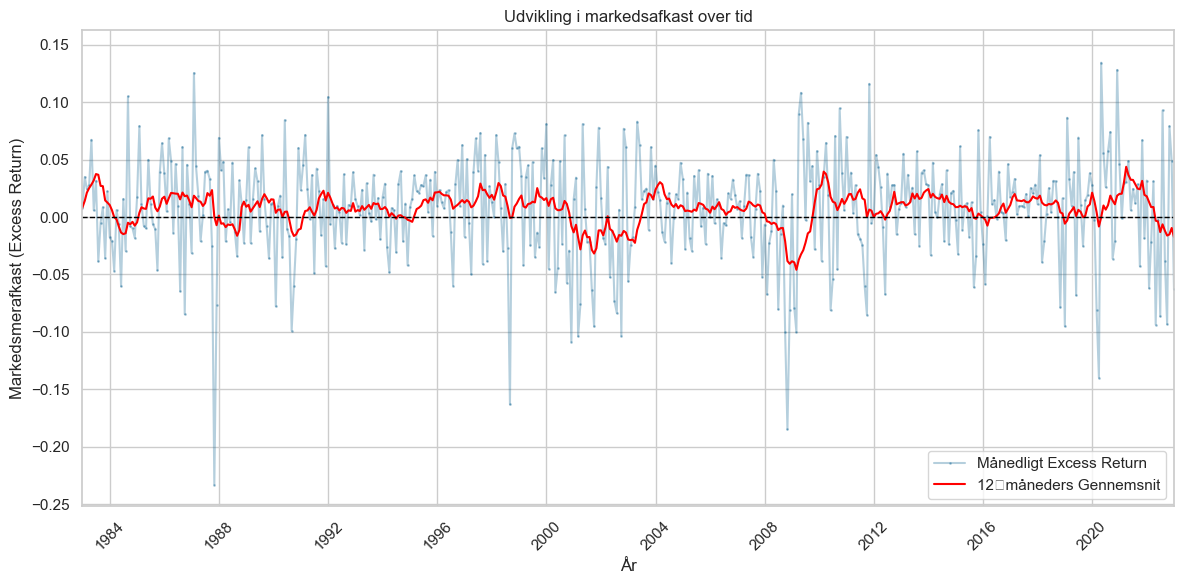

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# Antag at market_test allerede er dit DataFrame
market_test['eom'] = pd.to_datetime(market_test['eom'])
market_test['rolling_avg'] = market_test['mkt_vw_exc'].rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(
    market_test['eom'], market_test['mkt_vw_exc'],
    linestyle='-', marker='o', markersize=1, alpha=0.3,
    label="Månedligt Excess Return"
)
plt.plot(
    market_test['eom'], market_test['rolling_avg'],
    color='red', linewidth=1.5, label="12‑måneders Gennemsnit"
)
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Sæt x‑aksens start til 1982-12-31
start = pd.to_datetime('1982-12-31')
plt.xlim(start, market_test['eom'].max())

plt.xlabel("År")
plt.ylabel("Markedsmerafkast (Excess Return)")
plt.title("Udvikling i markedsafkast over tid")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
filename = "market_excess_return_rolling12m.png"
plt.savefig(os.path.join(output_path, filename), dpi=300, bbox_inches='tight')
plt.show()


In [65]:
output_path

'.\\new_data\\'

## Daily

In [61]:
daily_file_path = os.path.join(".", folder_name, "usa_dsf_test.parquet")
output_path_daily = os.path.join(".", folder_name, "daily.csv")
daily = pd.read_parquet(daily_file_path, engine='pyarrow')
daily = daily[(daily['ret_exc'].notna()) &
              (daily['id'] <= 99999) &
              (daily['id'].isin(chars.loc[chars['valid'] == True, 'id'].unique()))]

# Tilføj en ny kolonne 'eom' med månedens sidste dag
daily['eom'] = daily['date'] + MonthEnd(0)
daily.to_csv(output_path_daily, index=False)

In [62]:
daily = pd.read_csv(output_path_daily, parse_dates=["date", "eom"])

In [63]:
daily

,id,date,ret_exc,eom
0,10104,1986-03-13,0.023958,1986-03-31
1,10104,1986-03-14,0.035219,1986-03-31
2,10104,1986-03-17,-0.023141,1986-03-31
3,10104,1986-03-18,-0.023676,1986-03-31
4,10104,1986-03-19,-0.018248,1986-03-31
...,...,...,...,...
3430904,92655,2023-12-22,0.000624,2023-12-31
3430905,92655,2023-12-26,-0.000741,2023-12-31
3430906,92655,2023-12-27,0.005104,2023-12-31
3430907,92655,2023-12-28,0.003833,2023-12-31


## Færdig med daily

In [64]:
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
df_usa = pd.read_parquet(output_path_usa, engine='pyarrow')

In [65]:
df_usa.head()

,eom_ret,id,eom,valid_ret,excntry,me,sic,size_grp,ret_exc_lead1m,niq_su,...,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety,ctff_test,rvol_252d
0,1987-01-31,10104,1986-12-31,True,USA,277.19925,7370,small,0.297054,NaN,...,0.152201,-0.339631,0.518340,0.046991,NaN,0.658536,NaN,1.056774,False,0.036124
1,1987-02-28,10104,1987-01-31,True,USA,360.69300,7370,small,0.421617,NaN,...,0.152201,-0.339631,0.526047,0.047355,NaN,0.664785,NaN,1.093742,False,0.037220
2,1987-03-31,10104,1987-02-28,True,USA,514.32150,7370,large,0.137845,NaN,...,0.152201,-0.339631,0.585345,0.048170,NaN,0.679204,NaN,1.096833,False,0.037312
3,1987-04-30,10104,1987-03-31,True,USA,587.79600,7370,large,0.063897,NaN,...,-0.274303,-0.339631,0.776772,0.163565,NaN,-0.296627,NaN,1.002525,False,0.037813
4,1987-05-31,10104,1987-04-30,True,USA,627.87300,7370,large,0.155814,NaN,...,-0.274303,-0.339631,0.773349,0.169066,NaN,-0.305572,NaN,1.070931,False,0.037977


In [66]:
output_path_usa = os.path.join(".", folder_name, "usa_test.parquet")
df_usa = pd.read_parquet(output_path_usa, engine='pyarrow')
kolonner = ["excntry", "id", "eom", "ret_exc_lead1m"]
monthly = df_usa[kolonner]

# Omdøb kolonnen 'ret_exc_lead1m' til 'ret_exc'
monthly = monthly.rename(columns={"ret_exc_lead1m": "ret_exc"})

# Filtrer kun USA og id <= 99999
monthly = monthly[(monthly["excntry"] == "USA") & (monthly["id"] <= 99999)]

# Konverter 'eom' til datoformat
monthly["eom"] = pd.to_datetime(monthly["eom"], format="%Y%m%d")

# Initialiser en tom liste til resultater
results = []

# Loop over horisonter i h_list
for h in h_list:
    # Beregn langsigtede afkast
    data_ret = long_horizon_ret(data=monthly, h=h, impute="zero")

    # Tilføj 'eom_ret'
    data_ret["eom_ret"] = data_ret["eom"] + pd.DateOffset(months=1) + MonthEnd(0)
    # Filtrer til relevante kolonner
    data_ret_ld1 = data_ret[["id", "eom", "eom_ret", f"ret_ld{h}"]]

    # Merge med risikofri data
    data_ret_ld1 = data_ret_ld1.merge(risk_free, on="eom", how="left")

    # Beregn total return
    data_ret_ld1["tr_ld1"] = data_ret_ld1[f"ret_ld{h}"] + data_ret_ld1["rf"]
    data_ret_ld1.drop(columns=["rf"], inplace=True)

    # Tilføj horisont som kolonne
    data_ret_ld1["horizon"] = h

    # Gem resultatet for denne horisont
    results.append(data_ret_ld1)

# Kombiner alle resultater til én samlet DataFrame
final_result = pd.concat(results, ignore_index=True)
file_monthly_preprocessed_test = os.path.join(".", folder_name, "monthly_preprocessed_test.csv")
final_result.to_csv(file_monthly_preprocessed_test, index=False)

final_result

All missing excludes 1.44% of the observations


,id,eom,eom_ret,ret_ld1,tr_ld1,horizon
0,10104,1986-12-31,1987-01-31,0.421617,0.426517,1
1,10104,1987-01-31,1987-02-28,0.137845,0.142045,1
2,10104,1987-02-28,1987-03-31,0.063897,0.068197,1
3,10104,1987-03-31,1987-04-30,0.155814,0.160514,1
4,10104,1987-04-30,1987-05-31,-0.188517,-0.184117,1
...,...,...,...,...,...,...
153572,92655,2023-06-30,2023-07-31,-0.063368,NaN,1
153573,92655,2023-07-31,2023-08-31,0.057611,NaN,1
153574,92655,2023-08-31,2023-09-30,0.057504,NaN,1
153575,92655,2023-09-30,2023-10-31,0.028084,NaN,1


In [67]:
final_result["ret_ld1"].min()

-0.836336859

# Gamle predictions uden demean

In [84]:
#chars 

In [85]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = chars[col_name]

    pred_y_df = chars[['id', 'eom']].copy()

    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        print("train_test_val", train_test_val)
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # Gem model-output for den aktuelle horizon til en pickle-fil (svarer til R's saveRDS)
    model_filename = f"{output_path}/model_{h}.pkl"
    print("done med fil upload")
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


2000-12-31 00:00:00
datasættet er tomt; hvis ja, stop loopet
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 512.0, lambda: 12.494049928387, MSE: 0.010512457240698478
train_test_val {'val':            id        eom eom_pred_last  ret_pred    ocf_me    fcf_me  \
25      10104 1990-12-31    1991-01-31  0.138220  0.096970  0.079268   
26      10104 1991-01-31    1991-02-28 -0.004767  0.091463  0.079755   
27      10104 1991-02-28    1991-03-31 -0.004391  0.077844  0.072289   
28      10104 1991-03-31    1991-04-30  0.022443  0.071856  0.078313   
29      10104 1991-04-30    1991-05-31 -0.193650  0.082840  0.089286   
...       ...        ...           ...       ...       ...       ...   
116620  92655 2000-07-31    2000-08-31  0.150078  0.7006

In [34]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]

    pred_y_df = data_ret[['id', 'eom']].copy()

    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        print("train_test_val", train_test_val)
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # Gem model-output for den aktuelle horizon til en pickle-fil (svarer til R's saveRDS)
    model_filename = f"{output_path}/model_{h}.pkl"
    print("done med fil upload")
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


2000-12-31 00:00:00
datasættet er tomt; hvis ja, stop loopet
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 512.0, lambda: 22.90403581082864, MSE: 0.010637666215492645
train_test_val {'val':            id        eom eom_pred_last  ret_pred  qmj_safety  tax_gr1a  \
25      10104 1990-12-31    1991-01-31 -0.004767    0.126374  0.022222   
26      10104 1991-01-31    1991-02-28 -0.004391    0.121547  0.022346   
27      10104 1991-02-28    1991-03-31  0.022443    0.125000  0.027473   
28      10104 1991-03-31    1991-04-30 -0.193650    0.097826  0.032967   
29      10104 1991-04-30    1991-05-31  0.129162    0.117021  0.053763   
...       ...        ...           ...       ...         ...       ...   
116593  92655 2000-07-31    2000-08-31  

In [86]:

pred_list = []

for date, subdict in op.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    

    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print(all_preds_df.head())
print(all_preds_df.shape)
print(chars.shape)

      id        eom eom_pred_last      pred
0  10104 2000-12-31    2001-01-31  0.019173
1  10104 2001-01-31    2001-02-28  0.016186
2  10104 2001-02-28    2001-03-31 -0.001640
3  10104 2001-03-31    2001-04-30  0.001010
4  10104 2001-04-30    2001-05-31  0.006206
(80732, 4)
(125158, 130)


In [ ]:
op

In [68]:
output_path

'.\\new_data\\'

# Demeaned

In [103]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]

    pred_y_df = data_ret[['id', 'eom']].copy()

    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    # ----------------- NYT: De-mean afkastene -----------------
    # Beregn månedligt gennemsnit af afkastene baseret på 'eom'
    data_pred['mean_ret'] = data_pred.groupby('eom')['ret_pred'].transform('mean')
    print("mean data_pred",data_pred)
    # Beregn de-meanede afkast ved at trække det månedlige gennemsnit fra
    data_pred['ret_pred_demeaned'] = data_pred['ret_pred'] - data_pred['mean_ret']
    # Sørg for, at modellen trænes på de-meanede værdier
    data_pred['ret_pred'] = data_pred['ret_pred_demeaned']
    # -----------------------------------------------------------

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # ----------------- NYT: Gem månedlige gennemsnit -----------------
    monthly_means_df = (data_pred[['eom', 'mean_ret']]
                         .drop_duplicates()
                         .sort_values('eom')
                         .reset_index(drop=True))
    print("mean efter", monthly_means_df)
    # Tilføj den månedlige gennemsnits-DataFrame i output-dictionary'et
    print("op", op)
    op['monthly_means_df'] = monthly_means_df
    
    # -----------------------------------------------------------------

    # Gem model-output for den aktuelle horizon til en pickle-fil
    model_filename = f"{output_path}/demeaned_model_{h}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")

mean data_pred            id        eom eom_pred_last  ret_pred    ocf_me    fcf_me  \
0       10104 1988-11-30    1988-12-31  0.205772  0.310345  0.468531   
1       10104 1988-12-31    1989-01-31 -0.053729  0.248276  0.426573   
2       10104 1989-01-31    1989-02-28  0.066009  0.251701  0.441379   
3       10104 1989-02-28    1989-03-31  0.195263  0.258503  0.427586   
4       10104 1989-03-31    1989-04-30  0.043718  0.229730  0.356164   
...       ...        ...           ...       ...       ...       ...   
116857  92655 2022-07-31    2022-08-31 -0.026268  0.225806  0.399351   
116858  92655 2022-08-31    2022-09-30  0.096893  0.216828  0.400651   
116859  92655 2022-09-30    2022-10-31 -0.016168  0.197411  0.381107   
116860  92655 2022-10-31    2022-11-30 -0.032461  0.232258  0.425325   
116861  92655 2022-11-30    2022-12-31 -0.061958  0.270968  0.470779   

        cowc_gr1a  sale_gr1  seas_2_5na  ami_126d  ...        lambda  \
0        0.870229  0.970060    0.500000  0.65882

KeyboardInterrupt: 

In [117]:
data_pred['ret_pred_demeaned'].max()

2.390849029245

In [93]:
op

{datetime.datetime(2000, 12, 31, 0, 0): {'fit': Ridge(alpha=18.714393418062624, fit_intercept=False),
  'pred':           id        eom eom_pred_last      pred
  145    10104 2000-12-31    2001-01-31  0.006069
  146    10104 2001-01-31    2001-02-28  0.006135
  147    10104 2001-02-28    2001-03-31 -0.000773
  148    10104 2001-03-31    2001-04-30  0.004961
  149    10104 2001-04-30    2001-05-31  0.002654
  ...      ...        ...           ...       ...
  68334  92655 2001-07-31    2001-08-31  0.009565
  68335  92655 2001-08-31    2001-09-30  0.006961
  68336  92655 2001-09-30    2001-10-31  0.004775
  68337  92655 2001-10-31    2001-11-30  0.003011
  68338  92655 2001-11-30    2001-12-31  0.003180
  
  [1986 rows x 4 columns],
  'hp_search':              g    p        lambda       mse
  0     0.049787    2      0.000000  0.009392
  1     0.049787    2      0.000045  0.009392
  2     0.049787    2      0.000056  0.009392
  3     0.049787    2      0.000068  0.009392
  4     0.049787 

# WORKING one demeaning (BEST)

## med chars

In [81]:

search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = chars[col_name]

    pred_y_df = chars[['id', 'eom']].copy()
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    # ----------------- NYT: De-mean afkastene -----------------
    # Beregn månedligt gennemsnit af afkastene baseret på 'eom'
    data_pred['mean_ret'] = data_pred.groupby('eom')['ret_pred'].transform('mean')
    print("NaN i mean_ret kolonnen:")
    print(data_pred['mean_ret'][data_pred['mean_ret'].isna()])

    # Beregn de-meanede afkast ved at trække det månedlige gennemsnit fra
    data_pred['ret_pred_demeaned'] = data_pred['ret_pred'] - data_pred['mean_ret']
    # Sørg for, at modellen trænes på de-meanede værdier
    data_pred['ret_pred'] = data_pred['ret_pred_demeaned']
    # -----------------------------------------------------------

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver validerings-slutdato
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
      #  print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
    #    print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
     #       print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
     #   print("det vi gætter efter", train_test_val["val"]["ret_pred"])
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed= 10 #settings['seed_no']
        )
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # ----------------- NYT: Tilføj månedlige gennemsnit til forudsigelser -----------------
    # Opret DataFrame med månedlige gennemsnit
    monthly_means_df = (data_pred[['eom', 'mean_ret']]
                         .drop_duplicates()
                         .sort_values('eom')
                         .reset_index(drop=True))
    # For hver datetime-key i op skal vi merge monthly_means_df med 'pred'-DataFrame'en
    for key in list(op.keys()):
        if isinstance(key, datetime.datetime):
            model_dict = op[key]
            if 'pred' in model_dict:
                pred_df = model_dict['pred']
                # Merge på 'eom_pred_last' i pred_df og 'eom' i monthly_means_df
                pred_df = pred_df.merge(monthly_means_df, left_on='eom_pred_last', right_on='eom', how='left')
                pred_df = pred_df.drop(columns=['eom_x']).rename(columns={'eom_y': 'eom'}) # ny sørg for kun en eom
                print("pred_df før tilføjelse af pred_df", pred_df)
                # Re-add de-meanede afkast ved at lægge mean_ret til forudsigelsen
                pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
                print("pred_df efter tilføjelse af pred_df", pred_df)
                model_dict['pred'] = pred_df
                op[key] = model_dict

    # Gem model-output for den aktuelle horizon til en pickle-fil
    model_filename = f"{output_path}/demeaned_model_{h}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


NaN i mean_ret kolonnen:
Series([], Name: mean_ret, dtype: float64)
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 16.0, lambda: 0.0, MSE: 0.008837180083148672
Model training time: 32.447669982910156 seconds
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 512.0, lambda: 6.815448810083743, MSE: 0.009489896378862798
Model training time: 35.824607372283936 seconds
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 

# Forøg med at kigge tilbage i stedet for frem

In [123]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen
    h = search_grid.iloc[i]["horizon"]  # fx 1
    col_name = "ret_ld" + str(h)
    pred_y_values = chars[col_name]

    # Lav en kopi med de nødvendige kolonner
    pred_y_df = chars[['id', 'eom']].copy()
    # Bevar eom_pred_last, som data_split skal bruge
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    # Opret en kolonne til lookup: foregående måneds slutdato
    pred_y_df['eom_prev'] = pred_y_df['eom'] - MonthEnd(1)
    # Tilsæt afkastværdierne
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    # ----------------- DE-MEAN: Træk den foregående måneds gennemsnit fra -----------------
    # Udregn månedligt gennemsnit baseret på den foregående måneds dato (eom_prev)
    data_pred['mean_ret'] = data_pred.groupby('eom_prev')['ret_pred'].transform('mean')
    print("NaN i mean_ret kolonnen:")
    print(data_pred['mean_ret'][data_pred['mean_ret'].isna()])

    # Beregn de-meanede afkast
    data_pred['ret_pred_demeaned'] = data_pred['ret_pred'] - data_pred['mean_ret']
    # Sørg for, at modellen trænes på de-meanede værdier
    data_pred['ret_pred'] = data_pred['ret_pred_demeaned']
    # -----------------------------------------------------------------------------------------

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver validerings-slutdato
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
            print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        print("train_test_val", train_test_val)
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # ----------------- Gen-add: Læg den foregående måneds gennemsnit til forudsigelserne -----------------
    # Opret DataFrame med månedlige gennemsnit baseret på eom_prev
    monthly_means_df = (data_pred[['eom_prev', 'mean_ret']]
                         .drop_duplicates()
                         .sort_values('eom_prev')
                         .reset_index(drop=True))
    
    # For hver valideringsdato, merge monthly_means_df med forudsigelses-DataFrame'en
    for key in list(op.keys()):
        if isinstance(key, datetime.datetime):
            model_dict = op[key]
            if 'pred' in model_dict:
                pred_df = model_dict['pred']
                # Hvis pred_df ikke har 'eom_prev', kan vi genberegne den herfra ud fra 'eom'
                if 'eom_prev' not in pred_df.columns:
                    pred_df['eom_prev'] = pred_df['eom'] - MonthEnd(1)
                # Merge på eom_prev
                pred_df = pred_df.merge(monthly_means_df, on='eom_prev', how='left')
                print("pred_df før tilføjelse af monthly mean:", pred_df.head())
                # Genskab de oprindelige afkast ved at lægge mean_ret til de de-meanede forudsigelser
                pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
                print("pred_df efter tilføjelse af monthly mean:", pred_df.head())
                model_dict['pred'] = pred_df
                op[key] = model_dict
    # ---------------------------------------------------------------------------------------------
model_filename = f"{output_path}/demeaned_model_{h}_part2.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)

models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


NaN i mean_ret kolonnen:
Series([], Name: mean_ret, dtype: float64)
2000-12-31 00:00:00
datasættet er tomt; hvis ja, stop loopet
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16


KeyboardInterrupt: 

In [116]:
model_filename = f"{output_path}/demeaned_model_{h}_part2.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(op, f)

models.append(op)

In [117]:
op

{datetime.datetime(2000, 12, 31, 0, 0): {'fit': Ridge(alpha=8.341241958842371, fit_intercept=False),
  'pred':          id        eom eom_pred_last      pred   eom_prev  mean_ret
  0     10104 2000-12-31    2001-01-31  0.019823 2000-11-30  0.016064
  1     10104 2001-01-31    2001-02-28 -0.031240 2000-12-31 -0.032362
  2     10104 2001-02-28    2001-03-31 -0.069128 2001-01-31 -0.050923
  3     10104 2001-03-31    2001-04-30  0.072592 2001-02-28  0.087976
  4     10104 2001-04-30    2001-05-31  0.020782 2001-03-31  0.031099
  ...     ...        ...           ...       ...        ...       ...
  3450  92655 2001-07-31    2001-08-31 -0.035909 2001-06-30 -0.036748
  3451  92655 2001-08-31    2001-09-30 -0.102547 2001-07-31 -0.105584
  3452  92655 2001-09-30    2001-10-31  0.053275 2001-08-31  0.044286
  3453  92655 2001-10-31    2001-11-30  0.101983 2001-09-30  0.089713
  3454  92655 2001-11-30    2001-12-31  0.045847 2001-10-31  0.036332
  
  [3455 rows x 6 columns],
  'hp_search':       

In [119]:

pred_list = []

for date, subdict in op.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    

    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print(all_preds_df.head())
print(all_preds_df.shape)
print(chars.shape)

      id        eom eom_pred_last      pred   eom_prev  mean_ret
0  10104 2000-12-31    2001-01-31  0.019823 2000-11-30  0.016064
1  10104 2001-01-31    2001-02-28 -0.031240 2000-12-31 -0.032362
2  10104 2001-02-28    2001-03-31 -0.069128 2001-01-31 -0.050923
3  10104 2001-03-31    2001-04-30  0.072592 2001-02-28  0.087976
4  10104 2001-04-30    2001-05-31  0.020782 2001-03-31  0.031099
(80732, 6)
(125158, 130)


In [120]:

pred_list = []

for date, subdict in op.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    

    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print(all_preds_df.head())
print(all_preds_df.shape)
print(chars.shape)

      id        eom eom_pred_last      pred   eom_prev  mean_ret
0  10104 2000-12-31    2001-01-31  0.019823 2000-11-30  0.016064
1  10104 2001-01-31    2001-02-28 -0.031240 2000-12-31 -0.032362
2  10104 2001-02-28    2001-03-31 -0.069128 2001-01-31 -0.050923
3  10104 2001-03-31    2001-04-30  0.072592 2001-02-28  0.087976
4  10104 2001-04-30    2001-05-31  0.020782 2001-03-31  0.031099
(80732, 6)
(125158, 130)


In [89]:
pickle_file_path_1

'./data_fifty/demeaned_model_1.pkl'

In [122]:
pickle_file_path_1 = os.path.join(folder_name, "demeaned_model_1_part2.pkl")
with open(pickle_file_path_1, "rb") as file:
    demeaned_model_1 = pickle.load(file)

#print(model_1) #Vi bruger dog ikke ikke denne i selve 


pred_list = []

for date, subdict in demeaned_model_1.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    

    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print(all_preds_df.head())
print(all_preds_df.shape)
print(chars.shape)

      id        eom eom_pred_last      pred   eom_prev  mean_ret
0  10104 2000-12-31    2001-01-31  0.019823 2000-11-30  0.016064
1  10104 2001-01-31    2001-02-28 -0.031240 2000-12-31 -0.032362
2  10104 2001-02-28    2001-03-31 -0.069128 2001-01-31 -0.050923
3  10104 2001-03-31    2001-04-30  0.072592 2001-02-28  0.087976
4  10104 2001-04-30    2001-05-31  0.020782 2001-03-31  0.031099
(80732, 6)
(125158, 130)


## her bruges dataret?

In [70]:

search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1

    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]

    pred_y_df = data_ret[['id', 'eom']].copy()
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values

    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    # ----------------- NYT: De-mean afkastene -----------------
    # Beregn månedligt gennemsnit af afkastene baseret på 'eom'
    data_pred['mean_ret'] = data_pred.groupby('eom')['ret_pred'].transform('mean')
    print("NaN i mean_ret kolonnen:")
    print(data_pred['mean_ret'][data_pred['mean_ret'].isna()])

    # Beregn de-meanede afkast ved at trække det månedlige gennemsnit fra
    data_pred['ret_pred_demeaned'] = data_pred['ret_pred'] - data_pred['mean_ret']
    # Sørg for, at modellen trænes på de-meanede værdier
    data_pred['ret_pred'] = data_pred['ret_pred_demeaned']
    # -----------------------------------------------------------

    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver validerings-slutdato
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
      #  print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
    #    print("datasættet er tomt; hvis ja, stop loopet")
        if train_test_val["test"].empty:
     #       print("Test datasættet er tomt for valideringsperiode:", val_end, ". Stopper forudsigelser.")
            break
        model_start = time.time()
     #   print("det vi gætter efter", train_test_val["val"]["ret_pred"])
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed= 10 #settings['seed_no']
        )
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # ----------------- NYT: Tilføj månedlige gennemsnit til forudsigelser -----------------
    # Opret DataFrame med månedlige gennemsnit
    monthly_means_df = (data_pred[['eom', 'mean_ret']]
                         .drop_duplicates()
                         .sort_values('eom')
                         .reset_index(drop=True))
    # For hver datetime-key i op skal vi merge monthly_means_df med 'pred'-DataFrame'en
    for key in list(op.keys()):
        if isinstance(key, datetime.datetime):
            model_dict = op[key]
            if 'pred' in model_dict:
                pred_df = model_dict['pred']
                # Merge på 'eom_pred_last' i pred_df og 'eom' i monthly_means_df
                pred_df = pred_df.merge(monthly_means_df, left_on='eom_pred_last', right_on='eom', how='left')
                pred_df = pred_df.drop(columns=['eom_x']).rename(columns={'eom_y': 'eom'}) # ny sørg for kun en eom
                print("pred_df før tilføjelse af pred_df", pred_df)
                # Re-add de-meanede afkast ved at lægge mean_ret til forudsigelsen
                pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
                print("pred_df efter tilføjelse af pred_df", pred_df)
                model_dict['pred'] = pred_df
                op[key] = model_dict

    # Gem model-output for den aktuelle horizon til en pickle-fil
    model_filename = f"{output_path}/demeaned_model_{h}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


NaN i mean_ret kolonnen:
Series([], Name: mean_ret, dtype: float64)
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 16.0, lambda: 0.0, MSE: 0.008985668748046004
Model training time: 35.75983738899231 seconds
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.1353352832366127
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
Optimal g: 0.049787068367863944, p: 16.0, lambda: 0.0, MSE: 0.009487305318292767
Model training time: 36.82191348075867 seconds
g: 0.049787068367863944
  --> p: 2
  --> p: 4
  --> p: 8
  --> p: 16
  --> p: 32
  --> p: 64
  --> p: 128
  --> p: 256
  --> p: 512
g: 0.135335283236612

# SIKKERHEDSTJEK

In [112]:


for date, subdict in op.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    
    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print("Første par rækker:")
print(all_preds_df.head())
print("Samlet shape:", all_preds_df.shape)

# Beregn og udskriv antallet af NaNs i kolonnen 'pred'
nan_count_pred = all_preds_df['pred'].isna().sum()
print("Antal NaNs i 'pred':", nan_count_pred)

Første par rækker:
      id        eom eom_pred_last      pred   eom_prev  mean_ret
0  10104 2000-12-31    2001-01-31  0.019823 2000-11-30  0.016064
1  10104 2001-01-31    2001-02-28 -0.031240 2000-12-31 -0.032362
2  10104 2001-02-28    2001-03-31 -0.069128 2001-01-31 -0.050923
3  10104 2001-03-31    2001-04-30  0.072592 2001-02-28  0.087976
4  10104 2001-04-30    2001-05-31  0.020782 2001-03-31  0.031099
Samlet shape: (161464, 6)
Antal NaNs i 'pred': 0


In [114]:
chars.shape

(125158, 130)

In [98]:
file_path = os.path.join(output_path, f"model_{h}.pkl")
with open(file_path, 'rb') as f:
    op_old = pickle.load(f)
pred_list = []

for date, subdict in op_old.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    
    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print("Første par rækker:")
print(all_preds_df.head())
print("Samlet shape:", all_preds_df.shape)

# Beregn og udskriv antallet af NaNs i kolonnen 'pred'
nan_count_pred = all_preds_df['pred'].isna().sum()
print("Antal NaNs i 'pred':", nan_count_pred)

Første par rækker:
      id        eom eom_pred_last      pred
0  10104 2000-12-31    2001-01-31  0.019173
1  10104 2001-01-31    2001-02-28  0.016186
2  10104 2001-02-28    2001-03-31 -0.001640
3  10104 2001-03-31    2001-04-30  0.001010
4  10104 2001-04-30    2001-05-31  0.006206
Samlet shape: (80732, 4)
Antal NaNs i 'pred': 0


In [99]:
file_path = os.path.join(output_path, f"demeaned_model_{h}.pkl")
with open(file_path, 'rb') as f:
    op_new = pickle.load(f)
pred_list = []

for date, subdict in op_new.items():
    # Hent 'pred' DataFrame fra den aktuelle dictionary
    pred_df = subdict['pred'].copy()
    
    # Tilføj DataFrame'et til listen
    pred_list.append(pred_df)

# Saml alle DataFrames til ét samlet DataFrame
all_preds_df = pd.concat(pred_list, ignore_index=True)

# Udskriv de første par rækker
print("Første par rækker:")
print(all_preds_df.head())
print("Samlet shape:", all_preds_df.shape)

# Beregn og udskriv antallet af NaNs i kolonnen 'pred'
nan_count_pred = all_preds_df['pred'].isna().sum()
print("Antal NaNs i 'pred':", nan_count_pred)

Første par rækker:
      id eom_pred_last      pred        eom  mean_ret
0  10104    2001-01-31 -0.036089 2001-01-31 -0.032362
1  10104    2001-02-28 -0.057471 2001-02-28 -0.050923
2  10104    2001-03-31  0.079820 2001-03-31  0.087976
3  10104    2001-04-30  0.026325 2001-04-30  0.031099
4  10104    2001-05-31 -0.026902 2001-05-31 -0.021746
Samlet shape: (80732, 5)
Antal NaNs i 'pred': 307


In [102]:
file_path = os.path.join(output_path, f"model_{h}.pkl")
with open(file_path, 'rb') as f:
    op_new = pickle.load(f)
    
# Ekstraher alle 'pred'-dataframes i en liste
pred_list_new = []

# Gå igennem alle nøgler (valideringsdatoer) i dictionary'en
for val_end, subdict in op_new.items():
    if 'pred' in subdict:
        pred_df = subdict['pred'].copy()
        
        # Merge pred_df med monthly_means_df på eom_pred_last (fra pred_df) og eom (fra monthly_means_df)
        pred_df = pred_df.merge(monthly_means_df, left_on='eom_pred_last', right_on='eom', how='left')
        # Fjern evt. ekstra eom-kolonner og standardiser navnet
        pred_df = pred_df.drop(columns=['eom_x']).rename(columns={'eom_y': 'eom'})
        
        # Debug: Find rækker hvor mean_ret er NaN (altså hvor merge ikke fandt et match)
        missing_means = pred_df[pred_df['mean_ret'].isna()]
        if not missing_means.empty:
            print(f"Observationer med manglende monthly_mean for valideringsdato {val_end}:")
            # Udskriv nogle relevante kolonner, f.eks. id, eom_pred_last, pred
            print(missing_means[['id', 'eom_pred_last', 'pred']])
            print("Antal manglende:", missing_means.shape[0])
        
        # Re-add de-meanede afkast: Tilføj mean_ret til pred for at genskabe de oprindelige afkast
        # (Bemærk: Hvis mean_ret er NaN, bliver den nye pred NaN)
        pred_df['pred'] = pred_df['pred'] + pred_df['mean_ret']
        
        # Opdater dictionary'en for denne valideringsdato
        subdict['pred'] = pred_df
        
        # Tilføj den opdaterede pred_df til listen
        pred_list_new.append(pred_df)

# Sammensæt alle pred_df'er til én samlet DataFrame
all_preds_new_df = pd.concat(pred_list_new, ignore_index=True)

# Udskriv nogle stikprøver
print("Første par rækker for new:")
print(all_preds_new_df.head())
print("Samlet shape for new:", all_preds_new_df.shape)

# Beregn og udskriv antallet af NaNs i 'pred'
nan_count_new = all_preds_new_df['pred'].isna().sum()
print("Antal NaNs i 'pred' for new:", nan_count_new)

Observationer med manglende monthly_mean for valideringsdato 2021-12-31 00:00:00:
         id eom_pred_last      pred
11    10104    2022-12-31  0.010808
23    10107    2022-12-31  0.008957
35    10138    2022-12-31  0.012195
47    10145    2022-12-31  0.004702
59    10516    2022-12-31  0.013477
...     ...           ...       ...
3633  87432    2022-12-31  0.009325
3645  87447    2022-12-31  0.010567
3657  87717    2022-12-31  0.012543
3669  91556    2022-12-31  0.010668
3681  92655    2022-12-31  0.011935

[307 rows x 3 columns]
Antal manglende: 307
Første par rækker for new:
      id eom_pred_last      pred        eom  mean_ret
0  10104    2001-01-31 -0.013189 2001-01-31 -0.032362
1  10104    2001-02-28 -0.034737 2001-02-28 -0.050923
2  10104    2001-03-31  0.086336 2001-03-31  0.087976
3  10104    2001-04-30  0.032109 2001-04-30  0.031099
4  10104    2001-05-31 -0.015540 2001-05-31 -0.021746
Samlet shape for new: (80732, 5)
Antal NaNs i 'pred' for new: 307


In [79]:
chars.shape

(125158, 130)

In [75]:
import pandas as pd

# Filtrer rækker, hvor værdien i 'pred' er NaN
nan_preds = all_preds_df[all_preds_df['pred'].isna()]

# Gruppér efter 'forecast_date' og tæl antallet af NaN-rækker for hver dato
nan_counts = nan_preds.groupby('forecast_date').size()

# Print resultatet
print(nan_counts)


forecast_date
2021-12-31    307
dtype: int64


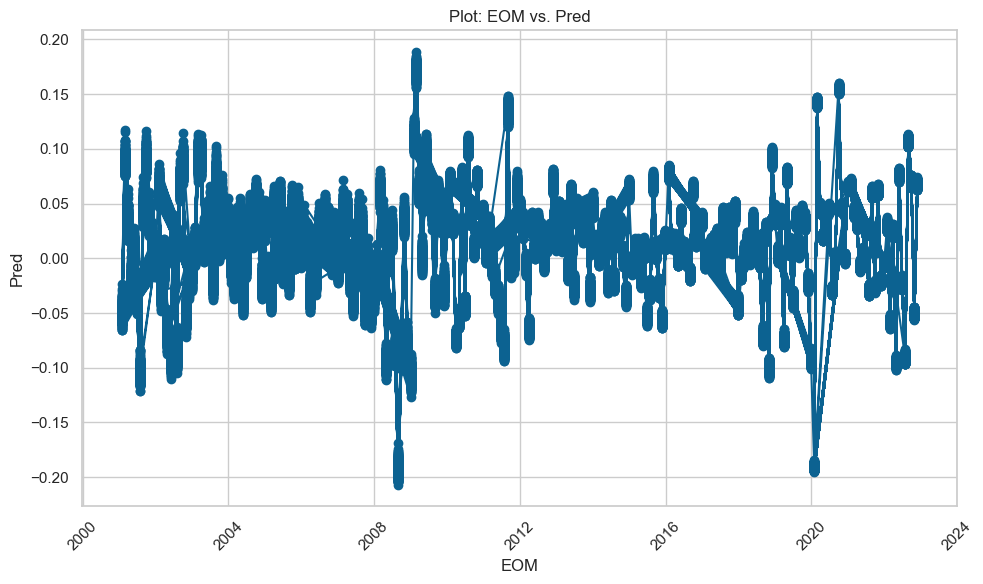

In [74]:
import matplotlib.pyplot as plt

# Sørg for, at 'eom' er i et passende format (fx datetime)
# Hvis 'eom' er en string, kan du eventuelt konvertere den til datetime:
# all_preds_df['eom'] = pd.to_datetime(all_preds_df['eom'])

plt.figure(figsize=(10,6))
plt.plot(all_preds_df['eom'], all_preds_df['pred'], marker='o', linestyle='-')
plt.xlabel('EOM')
plt.ylabel('Pred')
plt.title('Plot: EOM vs. Pred')
plt.xticks(rotation=45)  # Roter x-aksen etiketter, hvis der er mange
plt.tight_layout()        # Forbedrer layoutet ved f.eks. at undgå overlap
plt.show()


In [65]:
import datetime

In [36]:
output_path

'.\\new_data\\'

In [37]:

def rff_hp_search(data, feat, p_vec, g_vec, l_vec, seed):
    """
    Søger efter de optimale hyperparametre for Random Fourier Features og Ridge Regression.

    Args:
        data (dict): Dictionary med 'train', 'val', 'train_full' og 'test' DataFrames.
        feat (list): Liste over feature-kolonner.
        p_vec (list): Liste over værdier for antal Fourier-funktioner (skal være delbare med 2).
        g_vec (list): Liste over værdier for g (skala for vægte).
        l_vec (list): Liste over lambda (regulariseringsparametre) til Ridge Regression.
        seed (int): Seed for tilfældig vægtgeneration.

    Returns:
        dict: Dictionary med:
            - "fit": Den endelige Ridge Regression-model.
            - "pred": Forudsigelser for testdata som en DataFrame.
            - "hp_search": DataFrame med søgning over hyperparametre (g, p, lambda, mse).
            - "W": De optimale vægte (udtrukket fra rff_train for den optimale g).
            - "opt_hps": Den række med de optimale hyperparametre.
    """
    np.random.seed(seed)
    val_errors_list = []
    rff_info = {}  # Gemmer rff_train["W"] for hver g

    # Loop over g-værdier
    for g in g_vec:
        print(f"g: {g}")
        # Generer random Fourier features for træningsdata med p = max(p_vec)
        rff_train = rff(data["train"][feat].values, p=max(p_vec), g=g)
        # Brug de samme vægte til valideringsdata
        rff_val = rff(data["val"][feat].values, p=max(p_vec), W=rff_train["W"])

        # Loop over p-værdier
        for p in p_vec:
            print(f"  --> p: {p}")
            # Skalering: p^(-0.5) gange de første p/2 kolonner af cosine og sine
            half_p = int(p // 2)
            X_train = (p ** -0.5) * np.hstack((rff_train["X_cos"][:, :half_p],
                                               rff_train["X_sin"][:, :half_p]))
            X_val = (p ** -0.5) * np.hstack((rff_val["X_cos"][:, :half_p],
                                             rff_val["X_sin"][:, :half_p]))
            y_train = data["train"]["ret_pred"].values
            y_val = data["val"]["ret_pred"].values

            # Loop over lambda-værdier
            for lam in l_vec:
                model = Ridge(alpha=lam, fit_intercept=False)
                model.fit(X_train, y_train)
                preds = model.predict(X_val)
                mse = np.mean((preds - y_val) ** 2)
                val_errors_list.append({"g": g, "p": p, "lambda": lam, "mse": mse})

        # Gem W for den aktuelle g (kun én gang pr. g)
        rff_info[str(g)] = rff_train["W"]

    # Saml resultaterne i en DataFrame
    val_errors_df = pd.DataFrame(val_errors_list)
    # Find de hyperparametre med lavest MSE
    opt_idx = val_errors_df["mse"].idxmin()
    opt_hps = val_errors_df.loc[opt_idx]
    print(f"Optimal g: {opt_hps['g']}, p: {opt_hps['p']}, lambda: {opt_hps['lambda']}, MSE: {opt_hps['mse']}")

    # Hent de optimale weights for den valgte g: tag de første p/2 kolonner
    opt_g = str(opt_hps["g"])
    opt_p = int(opt_hps["p"])
    half_opt_p = int(opt_p // 2)
    opt_W = rff_info[opt_g][:, :half_opt_p]

    # Re-fit på train_full data
    rff_train_full = rff(data["train_full"][feat].values, p=opt_p, W=opt_W)
    X_train_full = (opt_p ** -0.5) * np.hstack((rff_train_full["X_cos"], rff_train_full["X_sin"]))
    y_train_full = data["train_full"]["ret_pred"].values
    final_model = Ridge(alpha=opt_hps["lambda"], fit_intercept=False)
    final_model.fit(X_train_full, y_train_full)

    # Forudsig på testdata
    rff_test = rff(data["test"][feat].values, p=opt_p, W=opt_W)
    X_test = (opt_p ** -0.5) * np.hstack((rff_test["X_cos"], rff_test["X_sin"]))
    preds_test = final_model.predict(X_test)

    # Opret en DataFrame med forudsigelser
    pred_op = data["test"][["id", "eom", "eom_pred_last"]].copy()
    pred_op["pred"] = preds_test

    return {
        "fit": final_model,
        "pred": pred_op,
        "hp_search": val_errors_df,
        "W": opt_W,
        "opt_hps": opt_hps
    }

           eom   ret_ld1
0   1982-12-31  0.016754
1   1983-01-31  0.036357
2   1983-02-28  0.033936
3   1983-03-31  0.069816
4   1983-04-30  0.016138
..         ...       ...
475 2022-07-31 -0.022165
476 2022-08-31 -0.091045
477 2022-09-30  0.107422
478 2022-10-31  0.069973
479 2022-11-30 -0.050821

[480 rows x 2 columns]


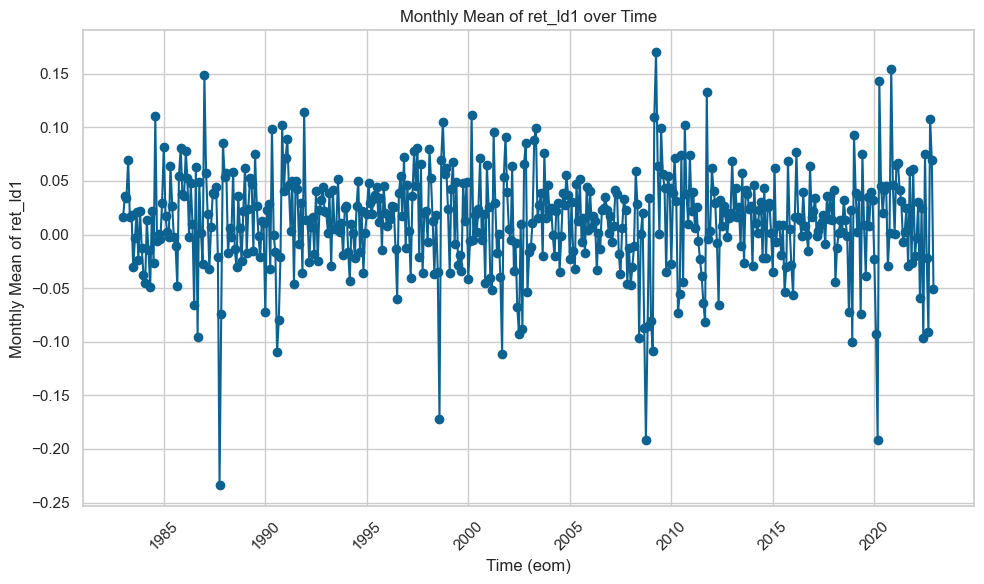

In [38]:
monthly_mean = chars.groupby('eom')['ret_ld1'].mean().reset_index()
print(monthly_mean)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_mean['eom'], monthly_mean['ret_ld1'], marker='o', linestyle='-')
plt.xlabel('Time (eom)')
plt.ylabel('Monthly Mean of ret_ld1')
plt.title('Monthly Mean of ret_ld1 over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plots af predictions

Indlæs beege som demeaned_model_1 og uden at have gjort noget model_1

In [2]:
import os

In [9]:
pickle_file_path_1 = os.path.join(folder_name, "demeaned_model_1.pkl")
with open(pickle_file_path_1, "rb") as file:
    demeaned_model_1 = pickle.load(file)
 

In [17]:
folder_name = "much_more_data"

In [11]:
pickle_file_path = os.path.join(folder_name, "model_1.pkl")
with open(pickle_file_path, "rb") as file:
    model_1 = pickle.load(file)


In [22]:
# Aggreger for model_1
pred_dfs = []
for key, subdict in model_1.items():
    if isinstance(key, datetime.datetime) and 'pred' in subdict:
        pred_dfs.append(subdict['pred'])
all_preds_df = pd.concat(pred_dfs, ignore_index=True)

# Aggreger for demeaned_model_1
pred_dfs = []
for key, subdict in demeaned_model_1.items():
    if isinstance(key, datetime.datetime) and 'pred' in subdict:
        pred_dfs.append(subdict['pred'])
all_preds_demeaned_df = pd.concat(pred_dfs, ignore_index=True)


In [23]:
all_preds_df

,id,eom,eom_pred_last,pred
0,10104,2000-12-31,2001-01-31,0.019173
1,10104,2001-01-31,2001-02-28,0.016186
2,10104,2001-02-28,2001-03-31,-0.001640
3,10104,2001-03-31,2001-04-30,0.001010
4,10104,2001-04-30,2001-05-31,0.006206
...,...,...,...,...
80727,92655,2022-07-31,2022-08-31,0.010673
80728,92655,2022-08-31,2022-09-30,0.009472
80729,92655,2022-09-30,2022-10-31,0.010354
80730,92655,2022-10-31,2022-11-30,0.010783


In [24]:
all_preds_demeaned_df

,id,eom,eom_pred_last,pred,eom_prev,mean_ret
0,10104,2000-12-31,2001-01-31,0.019823,2000-11-30,0.016064
1,10104,2001-01-31,2001-02-28,-0.031240,2000-12-31,-0.032362
2,10104,2001-02-28,2001-03-31,-0.069128,2001-01-31,-0.050923
3,10104,2001-03-31,2001-04-30,0.072592,2001-02-28,0.087976
4,10104,2001-04-30,2001-05-31,0.020782,2001-03-31,0.031099
...,...,...,...,...,...,...
80727,92655,2022-07-31,2022-08-31,-0.024667,2022-06-30,-0.023099
80728,92655,2022-08-31,2022-09-30,-0.093291,2022-07-31,-0.090910
80729,92655,2022-09-30,2022-10-31,0.104490,2022-08-31,0.106342
80730,92655,2022-10-31,2022-11-30,0.068537,2022-09-30,0.070133


In [25]:
import matplotlib.pyplot as plt

In [26]:
file_path_tickers = "Data/ticker_and_id.csv"

df_ticker = pd.read_csv(file_path_tickers)
print(df_ticker.head())
print(df_ticker.info())

   PERMNO TICKER                      COMNAM        date
0   15463   SPUN  VANECK VECTORS E T F TRUST  2018-08-01
1   91605   CPLA        CAPELLA EDUCATION CO  2018-08-01
2   16157   IGEM  VANECK VECTORS E T F TRUST  2018-08-01
3   92945    CYS       C Y S INVESTMENTS INC  2018-08-01
4   77279   ABAX                  ABAXIS INC  2018-08-01
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12480 entries, 0 to 12479
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PERMNO  12480 non-null  int64 
 1   TICKER  12479 non-null  object
 2   COMNAM  12480 non-null  object
 3   date    12480 non-null  object
dtypes: int64(1), object(3)
memory usage: 390.1+ KB
None


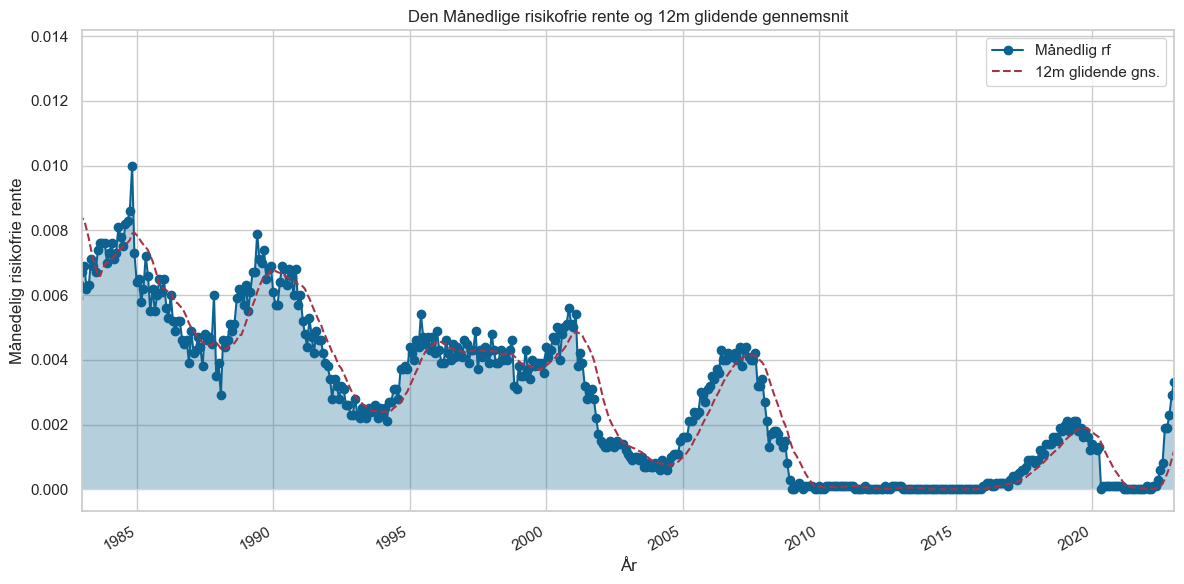

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

df_rf = risk_free.copy()
df_rf['eom'] = pd.to_datetime(df_rf['eom'])
df_rf = df_rf.sort_values('eom')

# Beregn 12‑måneders glidende gennemsnit
df_rf['rf_ma12'] = df_rf['rf'].rolling(12, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 6))

# 1) Plot rå rf‑serie
ax.plot(df_rf['eom'], df_rf['rf'],      marker='o', linestyle='-',  label='Månedlig rf')
# 2) Plot glidende gennemsnit
ax.plot(df_rf['eom'], df_rf['rf_ma12'], linestyle='--',             label='12m glidende gns.')
# 3) Fyld under kurven
ax.fill_between(df_rf['eom'], df_rf['rf'], alpha=0.3)

# 4) Formatér x‑aksen
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

# 5) Sæt x‑aksens start til 1982‑12‑31
start = pd.to_datetime('1982-12-31')
ax.set_xlim(start, df_rf['eom'].max())

# 6) Labels, titel, legend, grid
ax.set_xlabel('År')
ax.set_ylabel('Månedelig risikofrie rente')
ax.set_title('Den Månedlige risikofrie rente og 12m glidende gennemsnit')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "risk_free_plot.png"), dpi=300, bbox_inches='tight')
plt.show()


In [28]:
output_folder

'C:\\Users\\andre\\Documents\\4. semester Kandidatspeciale\\Billeder direkte fra koden'

In [29]:
df_rf

,eom,rf,rf_ma12
0,1952-12-31,0.0016,0.001600
1,1953-01-31,0.0016,0.001600
2,1953-02-28,0.0014,0.001533
3,1953-03-31,0.0018,0.001600
4,1953-04-30,0.0016,0.001600
...,...,...,...
836,2022-08-31,0.0019,0.000325
837,2022-09-30,0.0019,0.000483
838,2022-10-31,0.0023,0.000675
839,2022-11-30,0.0029,0.000917


In [30]:
# Filtrér df_ticker på de ønskede PERMNO’er
df_subset = df_ticker[df_ticker['PERMNO'].isin(ids)]

# Hold kun kolonnerne PERMNO og TICKER (fjern evt. dubletter)
tickers = (
    df_subset[['PERMNO','TICKER']]
    .drop_duplicates()
    .reset_index(drop=True)
)

print(tickers)

NameError: name 'ids' is not defined

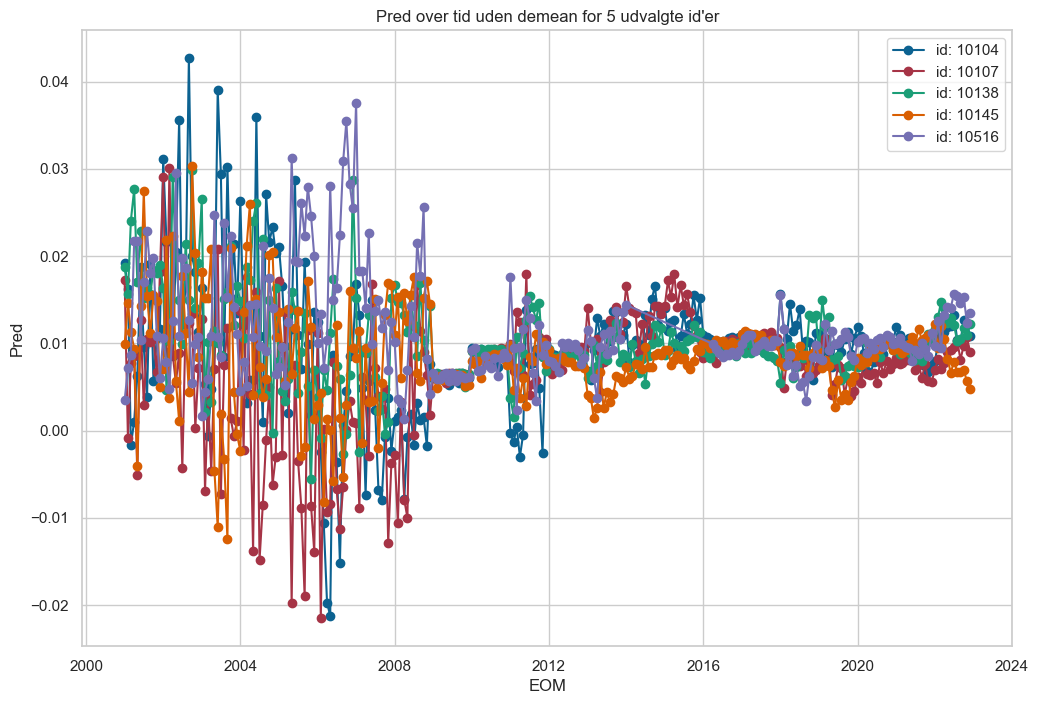

In [31]:
ids = all_preds_df['id'].unique()[:5]

# Filtrer data for de valgte id'er
df_subset = all_preds_df[all_preds_df['id'].isin(ids)].copy()

# Sørg for, at 'eom' er datetime
df_subset['eom'] = pd.to_datetime(df_subset['eom'])

# Plot "pred" over tid for hvert id
plt.figure(figsize=(12, 8))
for i in ids:
    df_temp = df_subset[df_subset['id'] == i]
    plt.plot(df_temp['eom'], df_temp['pred'], marker='o', label=f'id: {i}')

plt.xlabel('EOM')
plt.ylabel('Pred')
plt.title('Pred over tid uden demean for 5 udvalgte id\'er')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_folder, "5 udvalgte afkast forudsigelse uden demean.png"), dpi=300, bbox_inches='tight')
plt.show()

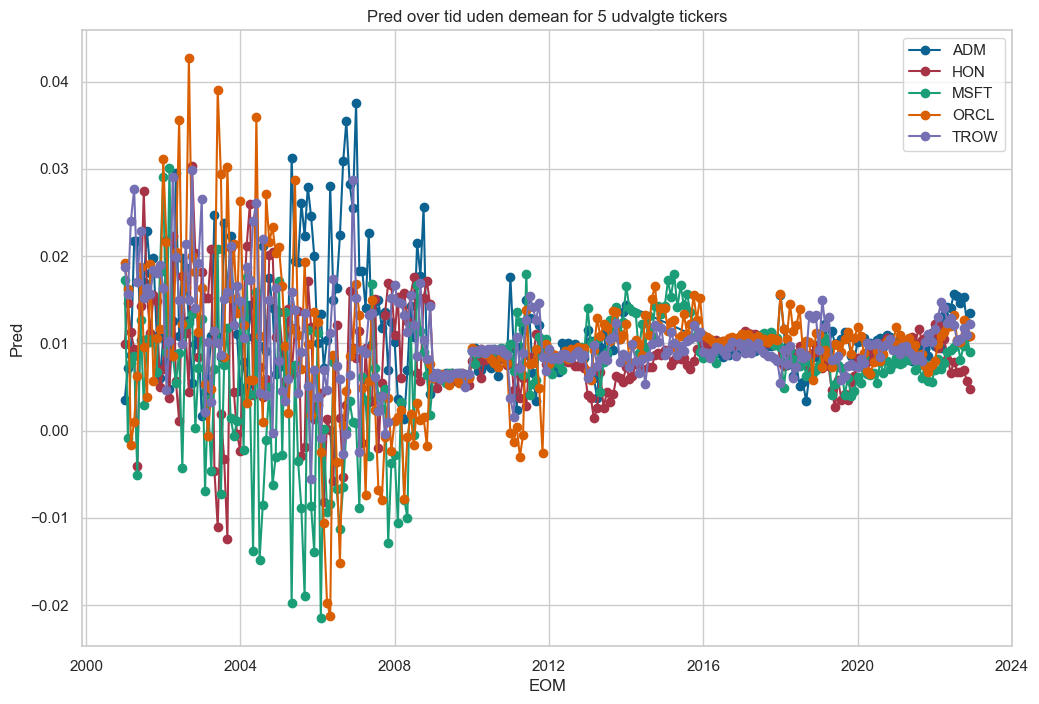

In [32]:
df_ticker = pd.read_csv("Data/ticker_and_id.csv")  
ticker_map = dict(zip(df_ticker["PERMNO"], df_ticker["TICKER"]))

# 2) Tag dine fem ids
ids = all_preds_df['id'].unique()[:5]

# 3) Filtrer og tilføj ticker
df_subset = all_preds_df[all_preds_df['id'].isin(ids)].copy()
df_subset['eom'] = pd.to_datetime(df_subset['eom'])
df_subset['ticker'] = df_subset['id'].map(ticker_map)

# 4) Plot med ticker i legend
plt.figure(figsize=(12,8))
for ticker, grp in df_subset.groupby('ticker'):
    plt.plot(grp['eom'], grp['pred'], marker='o', label=ticker)

plt.xlabel('EOM')
plt.ylabel('Pred')
plt.title("Pred over tid uden demean for 5 udvalgte tickers")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_folder,
            "5_udvalgte_afkast_forudsigelse_uden_demean.png"),
            dpi=300, bbox_inches='tight')
plt.show()

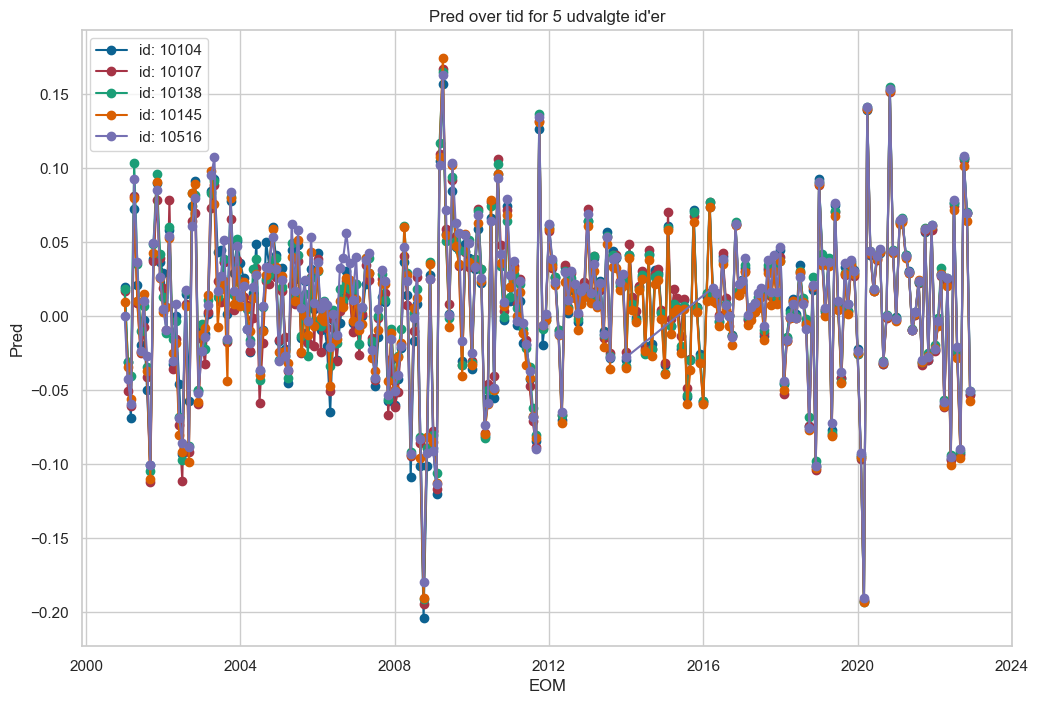

In [33]:
ids = all_preds_demeaned_df['id'].unique()[:5]

# Filtrer data for de valgte id'er
df_subset = all_preds_demeaned_df[all_preds_demeaned_df['id'].isin(ids)].copy()

# Sørg for, at 'eom' er datetime
df_subset['eom'] = pd.to_datetime(df_subset['eom'])

# Plot "pred" over tid for hvert id
plt.figure(figsize=(12, 8))
for i in ids:
    df_temp = df_subset[df_subset['id'] == i]
    plt.plot(df_temp['eom'], df_temp['pred'], marker='o', label=f'id: {i}')

plt.xlabel('EOM')
plt.ylabel('Pred')
plt.title('Pred over tid for 5 udvalgte id\'er')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_folder, "5 udvalgte afkast forudsigelse med demean.png"), dpi=300, bbox_inches='tight')
plt.show()

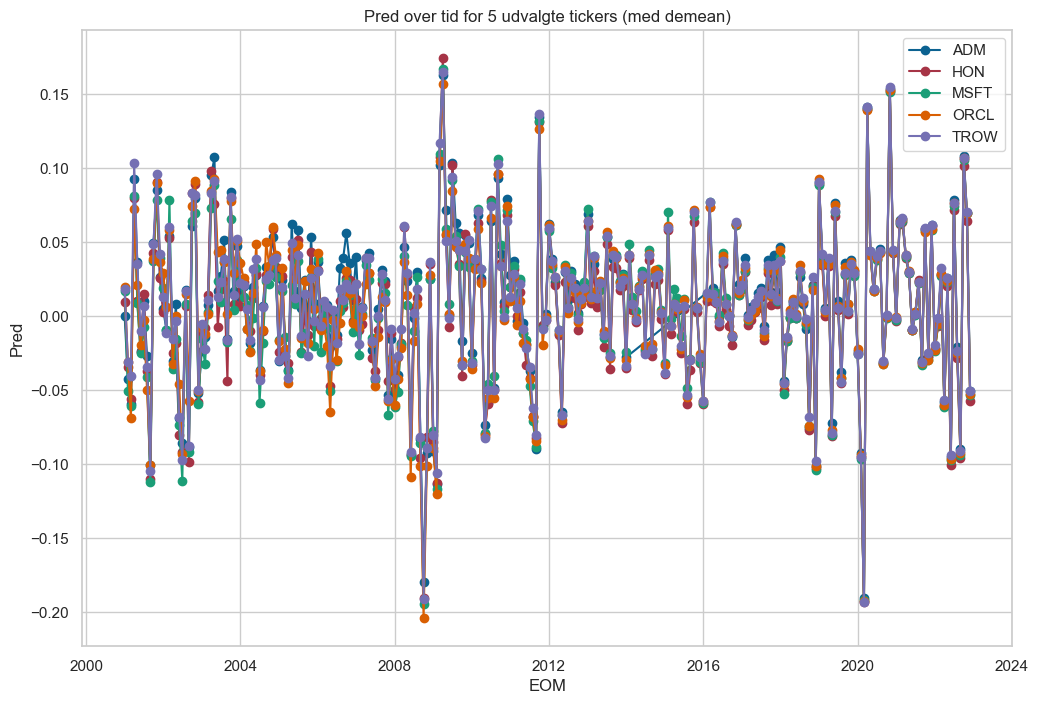

In [34]:
df_subset = all_preds_demeaned_df[all_preds_demeaned_df['id'].isin(ids)].copy()
df_subset['eom']    = pd.to_datetime(df_subset['eom'])
df_subset['ticker'] = df_subset['id'].map(ticker_map)

# 4) Plot med tickers i legend
plt.figure(figsize=(12, 8))
for ticker, grp in df_subset.groupby('ticker'):
    plt.plot(grp['eom'], grp['pred'], marker='o', label=ticker)

plt.xlabel('EOM')
plt.ylabel('Pred')
plt.title("Pred over tid for 5 udvalgte tickers (med demean)")
plt.legend()
plt.grid(True)

# 5) Gem og vis
filename = "5_udvalgte_afkast_forudsigelse_med_demean.png"
plt.savefig(os.path.join(output_folder, filename), dpi=300, bbox_inches='tight')
plt.show()

In [35]:
all_preds_demeaned_df

,id,eom,eom_pred_last,pred,eom_prev,mean_ret
0,10104,2000-12-31,2001-01-31,0.019823,2000-11-30,0.016064
1,10104,2001-01-31,2001-02-28,-0.031240,2000-12-31,-0.032362
2,10104,2001-02-28,2001-03-31,-0.069128,2001-01-31,-0.050923
3,10104,2001-03-31,2001-04-30,0.072592,2001-02-28,0.087976
4,10104,2001-04-30,2001-05-31,0.020782,2001-03-31,0.031099
...,...,...,...,...,...,...
80727,92655,2022-07-31,2022-08-31,-0.024667,2022-06-30,-0.023099
80728,92655,2022-08-31,2022-09-30,-0.093291,2022-07-31,-0.090910
80729,92655,2022-09-30,2022-10-31,0.104490,2022-08-31,0.106342
80730,92655,2022-10-31,2022-11-30,0.068537,2022-09-30,0.070133


In [36]:
# Filtrer de rækker, hvor pred_ld1 er NaN
missing_rows = all_preds_demeaned_df[all_preds_demeaned_df["pred"].isna()]

# Udskriv de første par rækker med kolonnerne 'eom' og 'pred_ld1'
print("De første rækker med NaN i pred:")
print(missing_rows[['eom', 'pred']].head())

# Antal rækker med NaN i pred_ld1
print("Antal NaN i pred_ld1:", len(missing_rows))

# Udtræk unikke datoer fra 'eom'-kolonnen i de filtrerede rækker
dates_with_missing = missing_rows['eom'].unique()
print("Datoer (eom) med NaN i pred_ld1:")
print(dates_with_missing)


De første rækker med NaN i pred:
Empty DataFrame
Columns: [eom, pred]
Index: []
Antal NaN i pred_ld1: 0
Datoer (eom) med NaN i pred_ld1:
<DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


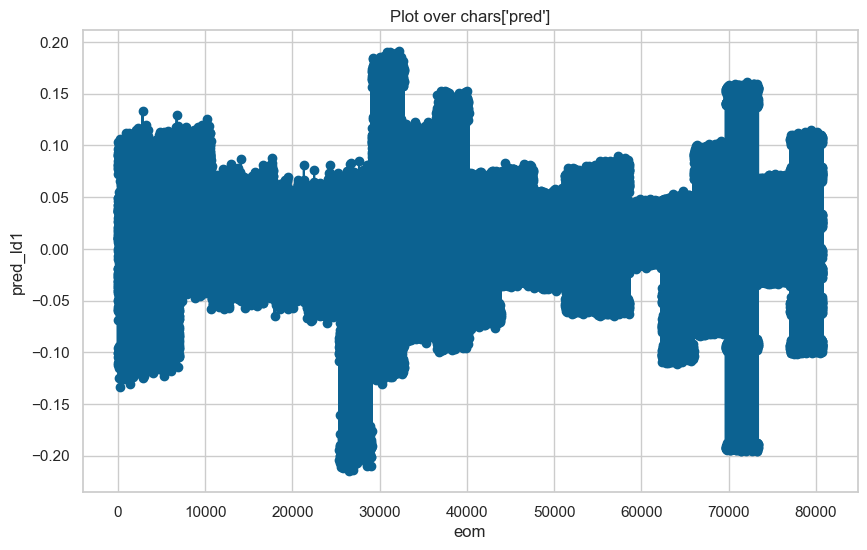

In [37]:
import matplotlib.pyplot as plt

# Antag at 'chars' er en pandas DataFrame og at 'pred_ld1' er en kolonne
plt.figure(figsize=(10, 6))
plt.plot(all_preds_demeaned_df["pred"], marker='o', linestyle='-')
plt.xlabel("eom")
plt.ylabel("pred_ld1")
plt.title("Plot over chars['pred']")
plt.grid(True)
plt.show()


## Optimal Lambda plots

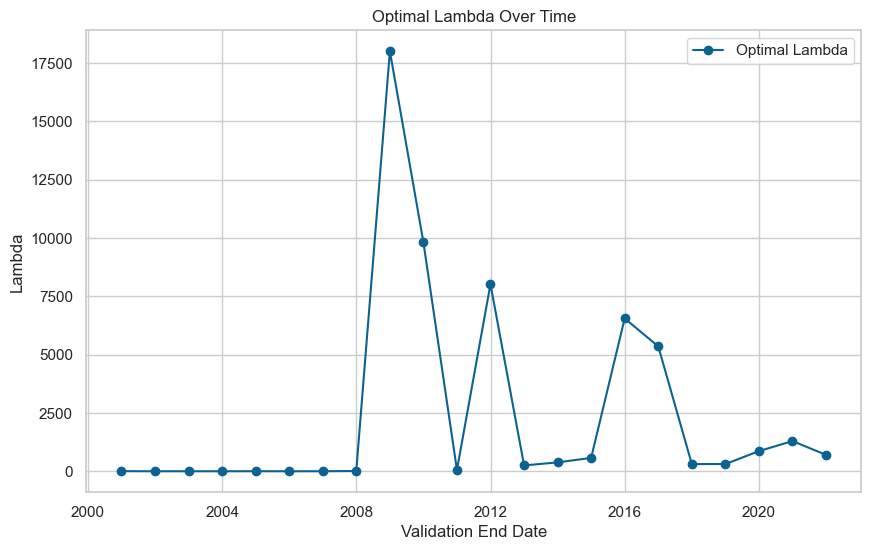

In [38]:
dates = sorted(model_1.keys())

# Plot 1: Optimal Lambda over tid
opt_lambdas = [model_1[d]['opt_hps']['lambda'] for d in dates]
plt.figure(figsize=(10,6))
plt.plot(dates, opt_lambdas, marker='o', label='Optimal Lambda')
plt.xlabel('Validation End Date')
plt.ylabel('Lambda')
plt.title('Optimal Lambda Over Time')
plt.legend()
plt.show()



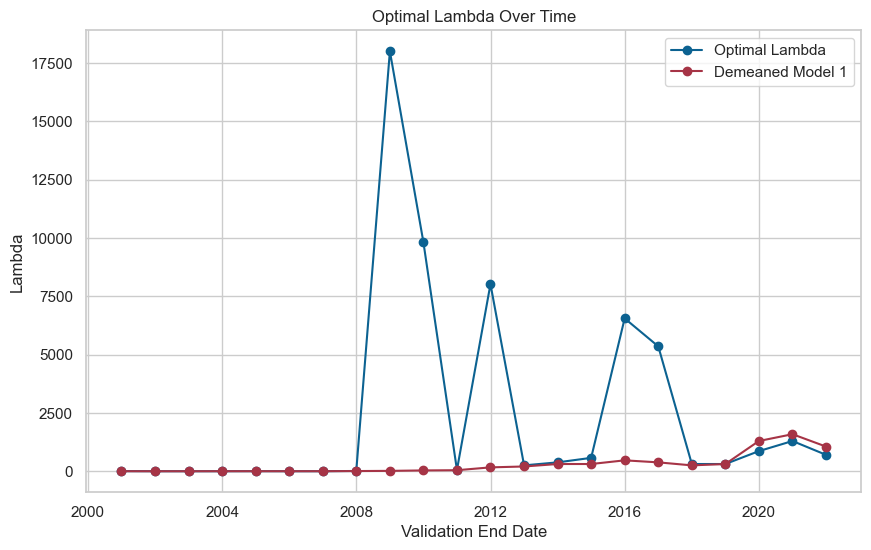

In [39]:

dates = sorted(model_1.keys())
opt_lambdas = [model_1[d]['opt_hps']['lambda'] for d in dates]
opt_lambdas_demeaned = [demeaned_model_1[d]['opt_hps']['lambda'] for d in dates]

plt.figure(figsize=(10,6))
plt.plot(dates, opt_lambdas, marker='o', label='Optimal Lambda')
plt.plot(dates, opt_lambdas_demeaned, marker='o', label='Demeaned Model 1')
plt.xlabel('Validation End Date')
plt.ylabel('Lambda')
plt.title('Optimal Lambda Over Time')
plt.legend()
plt.savefig(os.path.join(output_folder, "Optimal lambda for begge modeller.png"), dpi=300, bbox_inches='tight')
plt.show()


## HP Search

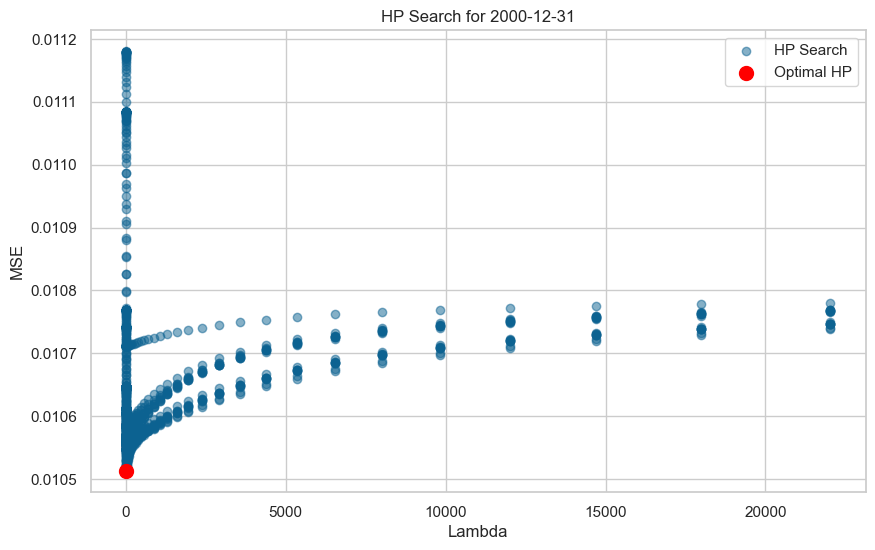

In [40]:
# Plot 2: HP Search Scatter Plot for en given periode (her den første dato)
date0 = dates[0]
hp_search_df = model_1[date0]['hp_search']
plt.figure(figsize=(10,6))
plt.scatter(hp_search_df['lambda'], hp_search_df['mse'], alpha=0.5, label='HP Search')
# Marker den optimale hyperparameter
opt_point = model_1[date0]['opt_hps']
plt.scatter(opt_point['lambda'], opt_point['mse'], color='red', label='Optimal HP', s=100)
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title(f'HP Search for {date0.date()}')
plt.legend()
plt.show()

In [50]:
dates

[datetime.datetime(2000, 12, 31, 0, 0),
 datetime.datetime(2001, 12, 31, 0, 0),
 datetime.datetime(2002, 12, 31, 0, 0),
 datetime.datetime(2003, 12, 31, 0, 0),
 datetime.datetime(2004, 12, 31, 0, 0),
 datetime.datetime(2005, 12, 31, 0, 0),
 datetime.datetime(2006, 12, 31, 0, 0),
 datetime.datetime(2007, 12, 31, 0, 0),
 datetime.datetime(2008, 12, 31, 0, 0),
 datetime.datetime(2009, 12, 31, 0, 0),
 datetime.datetime(2010, 12, 31, 0, 0),
 datetime.datetime(2011, 12, 31, 0, 0),
 datetime.datetime(2012, 12, 31, 0, 0),
 datetime.datetime(2013, 12, 31, 0, 0),
 datetime.datetime(2014, 12, 31, 0, 0),
 datetime.datetime(2015, 12, 31, 0, 0),
 datetime.datetime(2016, 12, 31, 0, 0),
 datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 12, 31, 0, 0),
 datetime.datetime(2019, 12, 31, 0, 0),
 datetime.datetime(2020, 12, 31, 0, 0),
 datetime.datetime(2021, 12, 31, 0, 0)]

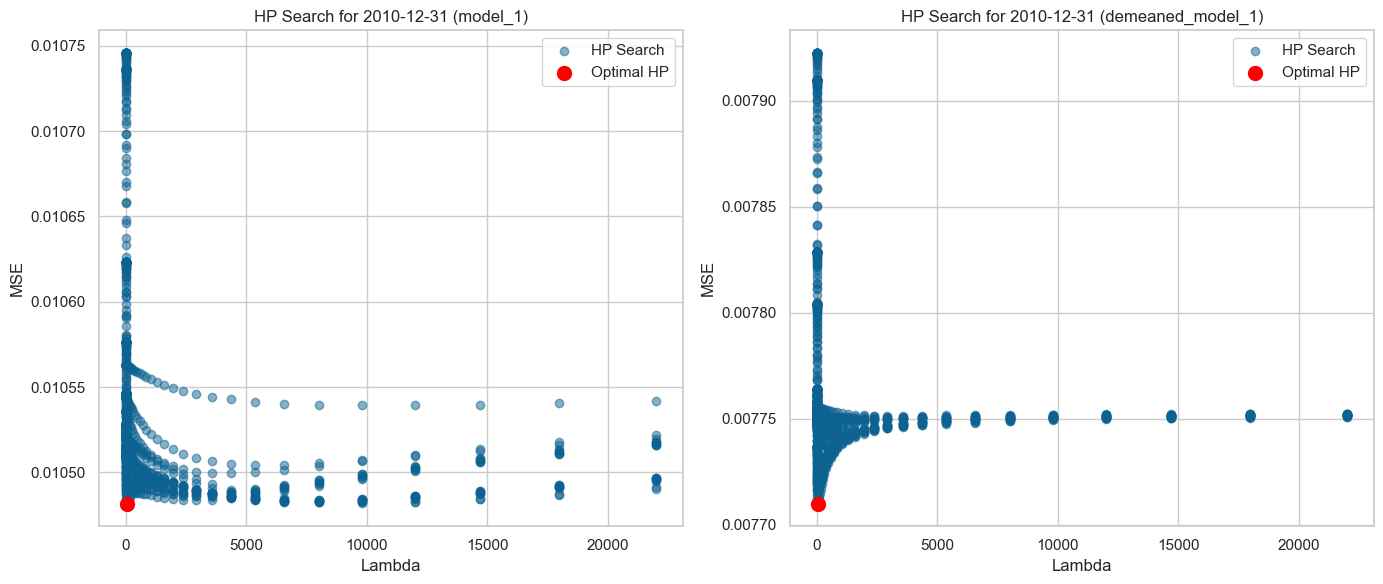

In [51]:
# Vælg den dato, du vil plotte for (her den første dato)
date0 = dates[10]
#date0 = dates[-1]
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Plot for model_1
hp_search_df = model_1[date0]['hp_search']
axes[0].scatter(hp_search_df['lambda'], hp_search_df['mse'], alpha=0.5, label='HP Search')
opt_point = model_1[date0]['opt_hps']
axes[0].scatter(opt_point['lambda'], opt_point['mse'], color='red', label='Optimal HP', s=100)
axes[0].set_xlabel('Lambda')
axes[0].set_ylabel('MSE')
axes[0].set_title(f'HP Search for {date0.date()} (model_1)')
axes[0].legend()

# Plot for demeaned_model_1
hp_search_df_demeaned = demeaned_model_1[date0]['hp_search']
axes[1].scatter(hp_search_df_demeaned['lambda'], hp_search_df_demeaned['mse'], alpha=0.5, label='HP Search')
opt_point_demeaned = demeaned_model_1[date0]['opt_hps']
axes[1].scatter(opt_point_demeaned['lambda'], opt_point_demeaned['mse'], color='red', label='Optimal HP', s=100)
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('MSE')
axes[1].set_title(f'HP Search for {date0.date()} (demeaned_model_1)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Optimal HP for alle years

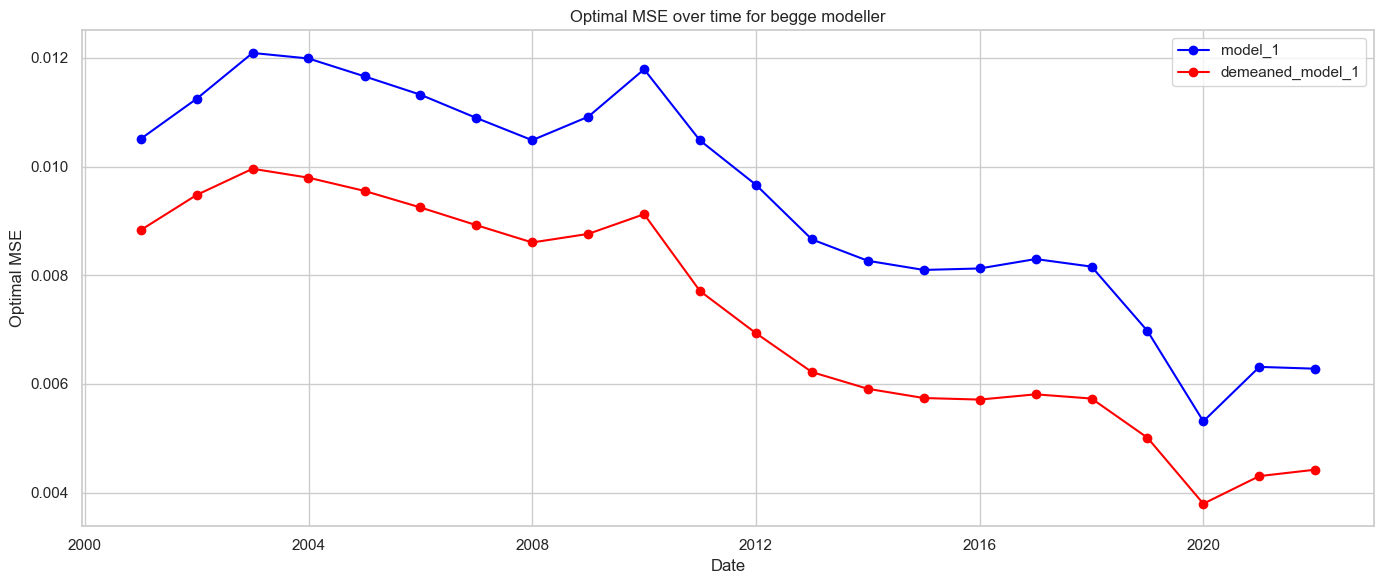

In [52]:
dates = sorted(model_1.keys())

# Udtræk optimal MSE for hver dato for model_1 og demeaned_model_1
opt_mses_model1 = [model_1[d]['opt_hps']['mse'] for d in dates]
opt_mses_demeaned = [demeaned_model_1[d]['opt_hps']['mse'] for d in dates]

# Opret et enkelt plot med ét sæt akser
fig, ax = plt.subplots(figsize=(14, 6))

# Plot for model_1
ax.plot(dates, opt_mses_model1, marker='o', linestyle='-', label='model_1', color='blue')
# Plot for demeaned_model_1
ax.plot(dates, opt_mses_demeaned, marker='o', linestyle='-', label='demeaned_model_1', color='red')

# Tilpas akse-labels og titel
ax.set_xlabel("Date")
ax.set_ylabel("Optimal MSE")
ax.set_title("Optimal MSE over time for begge modeller")
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "MSE for begge modeller.png"), dpi=300, bbox_inches='tight')
plt.show()


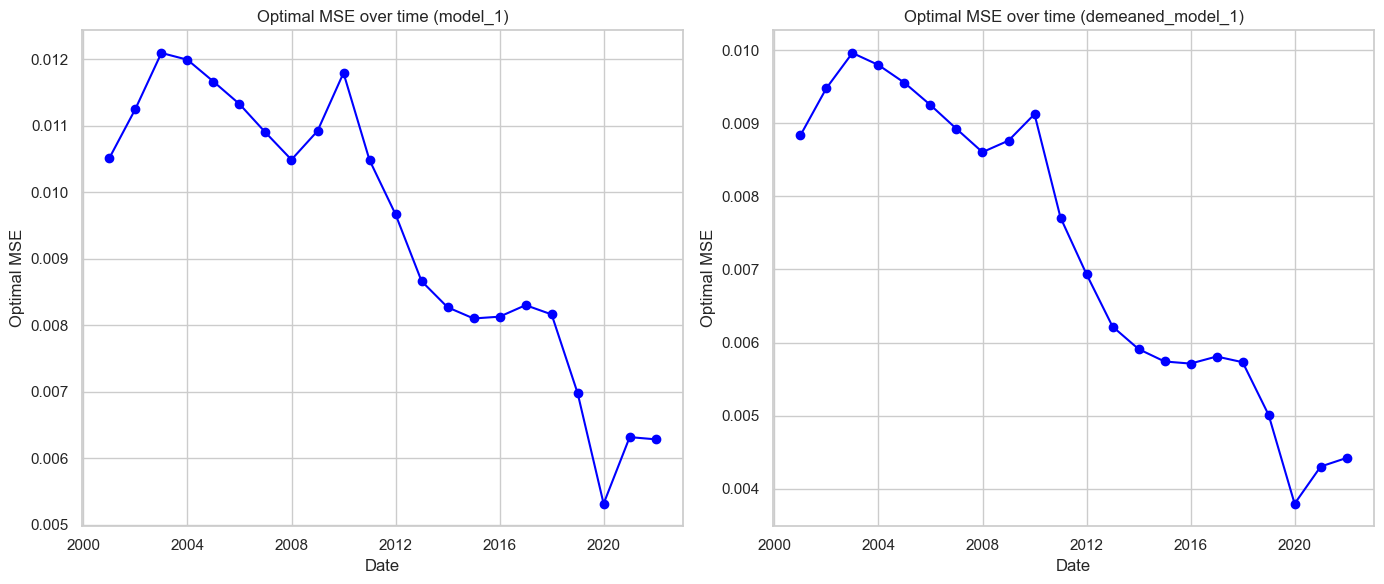

In [53]:
dates = sorted(model_1.keys())

# Udtræk optimal MSE for hver dato for model_1
opt_mses_model1 = [model_1[d]['opt_hps']['mse'] for d in dates]

# Udtræk optimal MSE for hver dato for demeaned_model_1
opt_mses_demeaned = [demeaned_model_1[d]['opt_hps']['mse'] for d in dates]

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Plot for model_1: Optimal MSE over tid
axes[0].plot(dates, opt_mses_model1, marker='o', linestyle='-', color='blue')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Optimal MSE")
axes[0].set_title("Optimal MSE over time (model_1)")

# Plot for demeaned_model_1: Optimal MSE over tid
axes[1].plot(dates, opt_mses_demeaned, marker='o', linestyle='-', color='blue')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Optimal MSE")
axes[1].set_title("Optimal MSE over time (demeaned_model_1)")

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "MSE for begge modeller.png"), dpi=300, bbox_inches='tight')
plt.show()

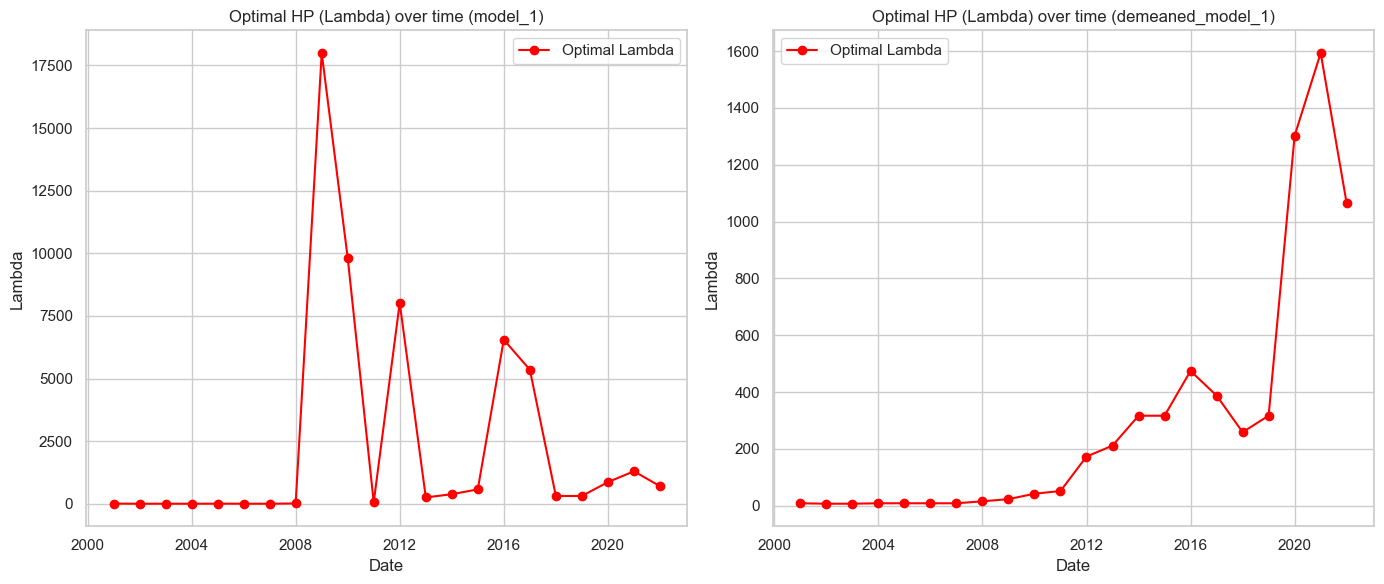

In [54]:
dates = sorted(model_1.keys())

# Udtræk de optimale hyperparametre (lambda og evt. mse) for model_1
opt_lambdas = [model_1[d]['opt_hps']['lambda'] for d in dates]
opt_mses = [model_1[d]['opt_hps']['mse'] for d in dates]

# Udtræk de optimale hyperparametre for demeaned_model_1
opt_lambdas_demeaned = [demeaned_model_1[d]['opt_hps']['lambda'] for d in dates]
opt_mses_demeaned = [demeaned_model_1[d]['opt_hps']['mse'] for d in dates]

fig, axes = plt.subplots(ncols=2, figsize=(14,6))

# Plot for model_1 – her plottes lambda over tid
axes[0].plot(dates, opt_lambdas, marker='o', linestyle='-', color='red', label='Optimal Lambda')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Lambda")
axes[0].set_title("Optimal HP (Lambda) over time (model_1)")
axes[0].legend()

# Plot for demeaned_model_1 – her plottes lambda over tid
axes[1].plot(dates, opt_lambdas_demeaned, marker='o', linestyle='-', color='red', label='Optimal Lambda')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Lambda")
axes[1].set_title("Optimal HP (Lambda) over time (demeaned_model_1)")
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "Optimal lambda for begge modeller.png"), dpi=300, bbox_inches='tight')
plt.show()

In [55]:
output_folder

'C:\\Users\\andre\\Documents\\4. semester Kandidatspeciale\\Billeder direkte fra koden'

## Prediction Distribution for 2000-12-31 

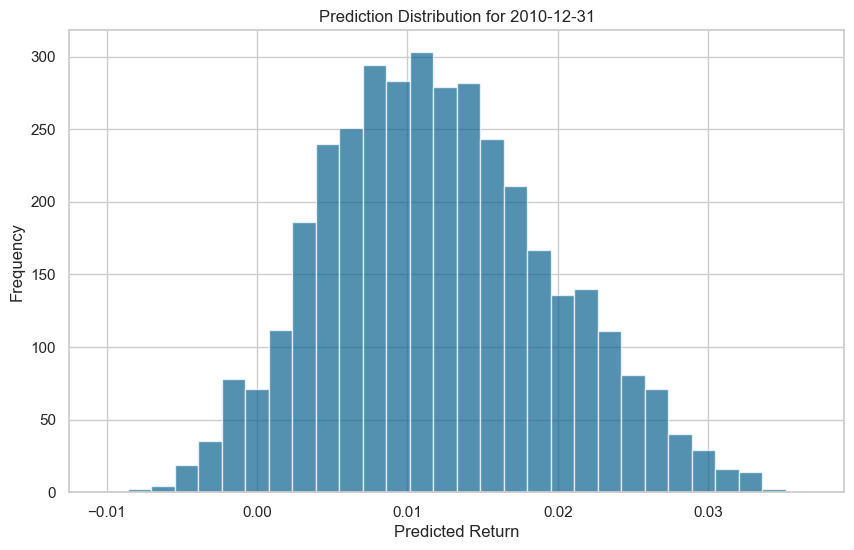

In [56]:
# Plot 3: Histogram af forudsigelser for en given periode
pred_df = model_1[date0]['pred']
plt.figure(figsize=(10,6))
plt.hist(pred_df['pred'], bins=30, alpha=0.7)
plt.xlabel('Predicted Return')
plt.ylabel('Frequency')
plt.title(f'Prediction Distribution for {date0.date()}')
plt.show()

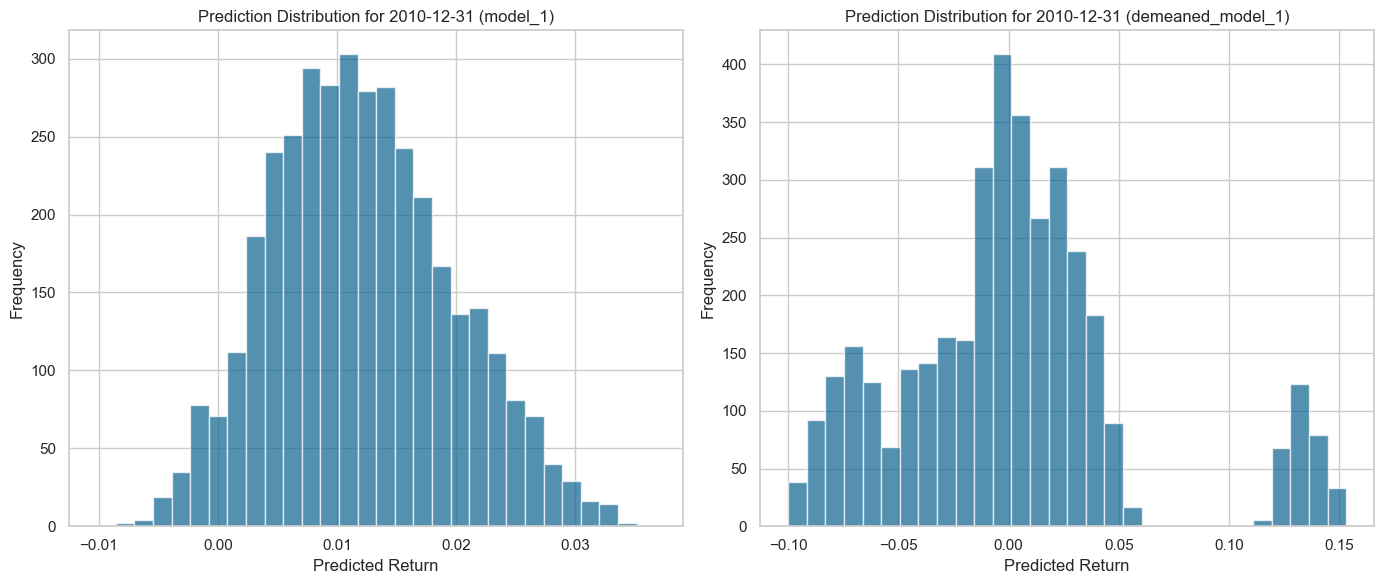

In [57]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Histogram for model_1
pred_df = model_1[date0]['pred']
axes[0].hist(pred_df['pred'], bins=30, alpha=0.7)
axes[0].set_xlabel('Predicted Return')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Prediction Distribution for {date0.date()} (model_1)')

# Histogram for demeaned_model_1
pred_df_demeaned = demeaned_model_1[date0]['pred']
axes[1].hist(pred_df_demeaned['pred'], bins=30, alpha=0.7)
axes[1].set_xlabel('Predicted Return')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Prediction Distribution for {date0.date()} (demeaned_model_1)')

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "prediction fordeling begge modeller.png"), dpi=300, bbox_inches='tight')
plt.show()


In [35]:
output_folder

'C:\\Users\\andre\\Documents\\4. semester Kandidatspeciale\\Billeder direkte fra koden'